# Постановка задачи
Виртуальные ассистенты, устройства Internet-of-Things все больше входят в жизнь современного человека. Они не только помогают автоматизировать поисковые запросы, распознают лица и речь, выполняют простейшие команды, но и учатся вести мониторинг состояния здоровья, детектировать различные ситуации, информировать о важных для пользователя событиях.

Для того, чтобы виртуальные ассистенты реагировали только на голос человека, присутствующего перед устройством, и не принимали во внимание речь из телевизора, радио, а также синтезированную, воспроизводимую роботами и другую, звучащую из динамиков, необходимы детекторы “живого” голоса.

Данная задача посвящена детектированию наличия “живого” голоса (класс 1) и его отделению от синтетического/конвертированного/перезаписанного голоса (класс 2).

Предлагается разработать систему с использованием элементов машинного
обучения, которая обучается на заданной обучающей базе аудиозаписей и должна быть протестирована на тестовой базе аудиозаписей.

# Исходные данные
1. Обучающая база данных:
a. Ссылка на базу: training_data
b. База имеет метки human (класс №1) и spoof (класс №2)

2. Тестовая база данных:
a. Ссылка на тестовую базу: testing_data
b. База не имеет меток правильных ответов

# Форма представления результата

1. Текстовый файл с ответами системы на тестовой базе в формате:
<имя файла>, <score>
где score - значение выхода системы детектирования. Чем выше score, тем больше уверенность системы в том, что в файле был записан “живой” голос.

2. Любая принципиально важная часть исходных кодов, по которой можно понять
алгоритм решения задачи

3. Собственные комментарии и замечания (по желанию)

Список литературы (опционально)

Основной список

https://www.isca-speech.org/archive/Interspeech_2018/pdfs/2279.pdf
    
http://www.apsipa.org/proceedings/2018/pdfs/0001047.pdf

   https://pdfs.semanticscholar.org/6a7b/88c8dc37850f8ffe48dcf7d839c6f0d47873.pdf

In [2]:
conda install -c conda-forge librosa

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\jetbrains\conda

  added / updated specs:
    - librosa


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    appdirs-1.4.4              |     pyh9f0ad1d_0          13 KB  conda-forge
    audioread-2.1.9            |   py38haa244fe_0          33 KB  conda-forge
    conda-4.10.3               |   py38haa244fe_2         3.1 MB  conda-forge
    libflac-1.3.3              |       h0e60522_1         324 KB  conda-forge
    libogg-1.3.4               |       h8ffe710_1          34 KB  conda-forge
    libopus-1.3.1              |       h8ffe710_1         255 KB  conda-forge
    librosa-0.8.1              |     pyhd8ed1ab_0         147 KB  conda-forge
    libsndfile-1.0.31          |       h0e60522_1         354 KB  conda-forge
    libvorbis-1.3.7            |       h0e60522_0         267 KB  conda-forge
    pooc



==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda







libvorbis-1.3.7      | 267 KB    |            |   0% 
libvorbis-1.3.7      | 267 KB    | 5          |   6% 
libvorbis-1.3.7      | 267 KB    | #1         |  12% 
libvorbis-1.3.7      | 267 KB    | #7         |  18% 
libvorbis-1.3.7      | 267 KB    | ####1      |  42% 
libvorbis-1.3.7      | 267 KB    | #####3     |  54% 
libvorbis-1.3.7      | 267 KB    | #######7   |  78% 
libvorbis-1.3.7      | 267 KB    | ########9  |  90% 
libvorbis-1.3.7      | 267 KB    | ########## | 100% 
libvorbis-1.3.7      | 267 KB    | ########## | 100% 

audioread-2.1.9      | 33 KB     |            |   0% 
audioread-2.1.9      | 33 KB     | ####8      |  48% 
audioread-2.1.9      | 33 KB     | ########## | 100% 

pysoundfile-0.10.3.p | 23 KB     |            |   0% 
pysoundfile-0.10.3.p | 23 KB     | ######8    |  69% 
pysoundfile-0.10.3.p | 23 KB     | ########## | 100% 

libsndfile-1.0.31    | 354 KB    |            |   0% 
libsndfile-1.0.31    | 354 KB    | 4          |   5% 
libsndfile-1.0.31    |

In [39]:
import librosa
import matplotlib.pyplot as plt

В качестве примера обработаем несколько файлов из тренировочного набора данных.

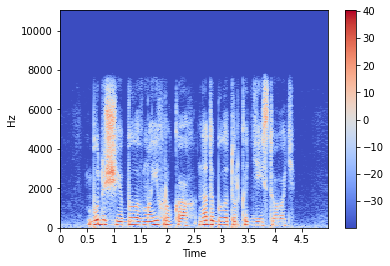

In [40]:
import matplotlib.pyplot as plt
import librosa.display

x_h, sr_h = librosa.load("Training_Data\\human\\human_00002.wav")

X_h = librosa.stft(x_h)
Xdb_h = librosa.amplitude_to_db(abs(X_h))

librosa.display.specshow(Xdb_h, sr=sr_h, x_axis='time', y_axis='hz')
plt.colorbar()

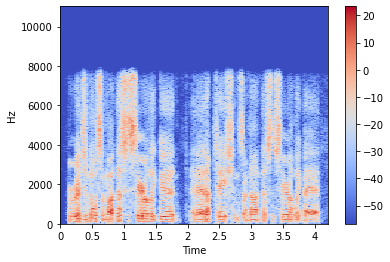

In [41]:
import matplotlib.pyplot as plt
import librosa.display

x_s, sr_s = librosa.load("Training_Data\\spoof\\spoof_00002.wav")

X_s = librosa.stft(x_s)
Xdb_s = librosa.amplitude_to_db(abs(X_s))

librosa.display.specshow(Xdb_s, sr=sr_s, x_axis='time', y_axis='hz')
plt.colorbar()

Для того, чтобы работать с аудиофайлами, необходимо выбрать ключевые особенности.
В качестве таковых были выбраны следующие особенности:

Разложение временного ряда аудио на гармонические и ударные компоненты(librosa.effects.hpss)

MFCC гармонической состовляющей аудио(количетво возврощаемых mfcc == 10)(librosa.feature.mfcc)

Отслеживание битов гармонической состовляющей аудио(librosa.beat.beat_track)

Нахождение частоты спада исходного аудио(librosa.feature.spectral_rolloff)

Вычисление спектрального контраста гармонической состовляющей(librosa.feature.spectral_contrast)

Частота перехода через 0 временного ряда гармонической состовляющей аудиозаписиlibrosa.feature.zero_crossing_rate

Спектральнаая полоса частот librosa.feature.spectral_bandwidth

Спектральный контраст librosa.feature.spectral_contrast

Спектральный центроид librosa.feature.spectral_centroid

У всех вычисленных характеристик было вычислено выборочное среднее и выборочное стандартное отклонение.

In [24]:
import librosa
import numpy as np
import librosa.display
import scipy
from scipy import stats

def get_features(wav_file_path):
    features = list()
    x, sr = librosa.load(wav_file_path, sr=None)
    n_mfc, n_cens = 10, 12

    x_harmonic, x_percussive = librosa.effects.hpss(x)
    
    mfc = librosa.feature.mfcc(y=x_harmonic, sr=sr, n_mfcc=n_mfc)
    tempo, _ = librosa.beat.beat_track(y=x_harmonic, sr=sr)
    sp_contrast = librosa.feature.spectral_contrast(y=x_harmonic, sr=sr)
    
    zcr = librosa.feature.zero_crossing_rate(x_harmonic)
    cens = librosa.feature.spectral_centroid(y=x, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=x_harmonic, sr=sr)
    sp_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=x_harmonic, sr=sr)
    
    data = np.concatenate((np.mean(sp_contrast,axis=1), np.std(sp_contrast,axis=1),
                           [np.mean(sp_rolloff), np.std(sp_rolloff)], [tempo],
                           [np.mean(zcr), np.std(zcr)], [np.mean(contrast), np.std(contrast)],
                           [np.mean(bandwidth), np.std(bandwidth)],
                           np.mean(mfc, axis=1)[0: n_mfc], np.std(mfc, axis=1)[0: n_mfc],
                           np.mean(cens, axis=1)[0: n_cens], np.std(cens, axis=1)[0: n_cens]), axis=0)
    
    features.extend(list(data))
  
    return features

Далее вычисляются характеристики тренировочных и тестовых данных и сохраняются в временные файлы, для избежания повторного вычисления.

In [25]:
import os

def get_data(way):
    data = list()
    
    for subdir, _, files in os.walk(way):
        for file in files:
            data.append(get_features(os.path.join(subdir, file)))
    return data

h_tr_data_way = 'Training_Data\\human'
s_tr_data_way = 'Training_Data\\spoof'

h_features = get_data(h_tr_data_way)
s_features = get_data(s_tr_data_way)

D:\jetbrains\conda\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


KeyboardInterrupt: 

In [6]:
def data_save(data_list: list, files_name: str, class_type: str):
    x_f = open(files_name + "_x.txt", 'w')
    y_f = open(files_name + "_y.txt", 'w')
    
    for i in data_list:
        x_f.write(' '.join([str(j) for j in i]) + '\n')
        y_f.write(class_type + '\n')
    
    x_f.close()
    y_f.close()

data_save(h_features, 'human', '1')
data_save(s_features, 'spoof', '2')

In [7]:
def get_test_data(way):
    data = list()
    list_files = list()
    
    for subdir, _, files in os.walk(way):
        list_files.extend(files)
        for file in files:
            data.append(get_features(os.path.join(subdir, file)))
    return (data, files)

test_data_way = 'Testing_Data'

test_data, list_files = get_test_data(test_data_way)

In [8]:
data_save(test_data, 'test', '0')
data_save(list_files, 'test_f_names', '0')

В качестве модели используется градиентный бустинг реализованный в библиотеке CatBoostClassifier.

In [75]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
estimators, iters = 2000, 2000

X_train = h_features + s_features
Y_train = [1] * len(h_features) + [2] * len(s_features)
boost = CatBoostClassifier(n_estimators=estimators)

score = cross_val_score(boost, X_train, Y_train, cv =5, 
                        scoring=make_scorer(accuracy_score, greater_is_better=False))
print(score)

Learning rate set to 0.026361
0:	learn: 0.6697643	total: 43.4ms	remaining: 1m 26s
1:	learn: 0.6471259	total: 74.2ms	remaining: 1m 14s
2:	learn: 0.6240804	total: 101ms	remaining: 1m 7s
3:	learn: 0.6044939	total: 130ms	remaining: 1m 5s
4:	learn: 0.5859087	total: 158ms	remaining: 1m 2s
5:	learn: 0.5685090	total: 186ms	remaining: 1m 1s
6:	learn: 0.5512388	total: 223ms	remaining: 1m 3s
7:	learn: 0.5340125	total: 252ms	remaining: 1m 2s
8:	learn: 0.5181197	total: 280ms	remaining: 1m 1s
9:	learn: 0.5029513	total: 312ms	remaining: 1m 2s
10:	learn: 0.4894352	total: 340ms	remaining: 1m 1s
11:	learn: 0.4780199	total: 368ms	remaining: 1m
12:	learn: 0.4670761	total: 404ms	remaining: 1m 1s
13:	learn: 0.4555852	total: 432ms	remaining: 1m 1s
14:	learn: 0.4457382	total: 460ms	remaining: 1m
15:	learn: 0.4368547	total: 489ms	remaining: 1m
16:	learn: 0.4279398	total: 519ms	remaining: 1m
17:	learn: 0.4189281	total: 554ms	remaining: 1m 1s
18:	learn: 0.4112843	total: 604ms	remaining: 1m 3s
19:	learn: 0.403543

160:	learn: 0.1715194	total: 5.99s	remaining: 1m 8s
161:	learn: 0.1710350	total: 6.02s	remaining: 1m 8s
162:	learn: 0.1705638	total: 6.05s	remaining: 1m 8s
163:	learn: 0.1700037	total: 6.09s	remaining: 1m 8s
164:	learn: 0.1695567	total: 6.11s	remaining: 1m 7s
165:	learn: 0.1689910	total: 6.14s	remaining: 1m 7s
166:	learn: 0.1684499	total: 6.19s	remaining: 1m 7s
167:	learn: 0.1679497	total: 6.22s	remaining: 1m 7s
168:	learn: 0.1673548	total: 6.25s	remaining: 1m 7s
169:	learn: 0.1670095	total: 6.28s	remaining: 1m 7s
170:	learn: 0.1666348	total: 6.31s	remaining: 1m 7s
171:	learn: 0.1662135	total: 6.34s	remaining: 1m 7s
172:	learn: 0.1657634	total: 6.37s	remaining: 1m 7s
173:	learn: 0.1652793	total: 6.4s	remaining: 1m 7s
174:	learn: 0.1649708	total: 6.43s	remaining: 1m 7s
175:	learn: 0.1644552	total: 6.46s	remaining: 1m 6s
176:	learn: 0.1639690	total: 6.49s	remaining: 1m 6s
177:	learn: 0.1635957	total: 6.52s	remaining: 1m 6s
178:	learn: 0.1632066	total: 6.55s	remaining: 1m 6s
179:	learn: 0

322:	learn: 0.1198526	total: 12.1s	remaining: 1m 3s
323:	learn: 0.1196851	total: 12.2s	remaining: 1m 2s
324:	learn: 0.1194874	total: 12.2s	remaining: 1m 2s
325:	learn: 0.1192374	total: 12.3s	remaining: 1m 2s
326:	learn: 0.1190277	total: 12.3s	remaining: 1m 2s
327:	learn: 0.1187565	total: 12.3s	remaining: 1m 2s
328:	learn: 0.1185901	total: 12.4s	remaining: 1m 2s
329:	learn: 0.1183279	total: 12.4s	remaining: 1m 2s
330:	learn: 0.1180981	total: 12.4s	remaining: 1m 2s
331:	learn: 0.1179288	total: 12.5s	remaining: 1m 2s
332:	learn: 0.1176710	total: 12.5s	remaining: 1m 2s
333:	learn: 0.1174510	total: 12.5s	remaining: 1m 2s
334:	learn: 0.1172868	total: 12.6s	remaining: 1m 2s
335:	learn: 0.1170759	total: 12.6s	remaining: 1m 2s
336:	learn: 0.1168810	total: 12.6s	remaining: 1m 2s
337:	learn: 0.1166477	total: 12.7s	remaining: 1m 2s
338:	learn: 0.1164312	total: 12.7s	remaining: 1m 2s
339:	learn: 0.1162760	total: 12.8s	remaining: 1m 2s
340:	learn: 0.1159817	total: 12.8s	remaining: 1m 2s
341:	learn: 

487:	learn: 0.0926287	total: 18.6s	remaining: 57.7s
488:	learn: 0.0924839	total: 18.7s	remaining: 57.7s
489:	learn: 0.0923071	total: 18.7s	remaining: 57.6s
490:	learn: 0.0921597	total: 18.7s	remaining: 57.6s
491:	learn: 0.0920581	total: 18.8s	remaining: 57.6s
492:	learn: 0.0919167	total: 18.8s	remaining: 57.6s
493:	learn: 0.0917230	total: 18.9s	remaining: 57.6s
494:	learn: 0.0916174	total: 18.9s	remaining: 57.6s
495:	learn: 0.0914637	total: 19s	remaining: 57.7s
496:	learn: 0.0912876	total: 19.1s	remaining: 57.7s
497:	learn: 0.0911728	total: 19.1s	remaining: 57.7s
498:	learn: 0.0910785	total: 19.2s	remaining: 57.8s
499:	learn: 0.0910103	total: 19.2s	remaining: 57.7s
500:	learn: 0.0908458	total: 19.3s	remaining: 57.8s
501:	learn: 0.0907148	total: 19.4s	remaining: 57.8s
502:	learn: 0.0906267	total: 19.4s	remaining: 57.7s
503:	learn: 0.0905130	total: 19.4s	remaining: 57.7s
504:	learn: 0.0903684	total: 19.5s	remaining: 57.7s
505:	learn: 0.0902068	total: 19.5s	remaining: 57.6s
506:	learn: 0.

648:	learn: 0.0749352	total: 25s	remaining: 52.1s
649:	learn: 0.0748479	total: 25.1s	remaining: 52.1s
650:	learn: 0.0747649	total: 25.1s	remaining: 52s
651:	learn: 0.0746349	total: 25.1s	remaining: 52s
652:	learn: 0.0745683	total: 25.2s	remaining: 51.9s
653:	learn: 0.0744882	total: 25.2s	remaining: 51.9s
654:	learn: 0.0743840	total: 25.3s	remaining: 51.9s
655:	learn: 0.0743118	total: 25.3s	remaining: 51.8s
656:	learn: 0.0742417	total: 25.3s	remaining: 51.8s
657:	learn: 0.0741575	total: 25.4s	remaining: 51.7s
658:	learn: 0.0740859	total: 25.4s	remaining: 51.7s
659:	learn: 0.0740038	total: 25.4s	remaining: 51.7s
660:	learn: 0.0738791	total: 25.5s	remaining: 51.6s
661:	learn: 0.0738174	total: 25.5s	remaining: 51.6s
662:	learn: 0.0736897	total: 25.5s	remaining: 51.5s
663:	learn: 0.0736044	total: 25.6s	remaining: 51.5s
664:	learn: 0.0735596	total: 25.6s	remaining: 51.4s
665:	learn: 0.0734774	total: 25.7s	remaining: 51.4s
666:	learn: 0.0733919	total: 25.7s	remaining: 51.3s
667:	learn: 0.0732

810:	learn: 0.0623076	total: 32.6s	remaining: 47.8s
811:	learn: 0.0622172	total: 32.7s	remaining: 47.8s
812:	learn: 0.0621438	total: 32.7s	remaining: 47.8s
813:	learn: 0.0620750	total: 32.8s	remaining: 47.7s
814:	learn: 0.0619724	total: 32.8s	remaining: 47.7s
815:	learn: 0.0619211	total: 32.9s	remaining: 47.7s
816:	learn: 0.0618529	total: 32.9s	remaining: 47.7s
817:	learn: 0.0618042	total: 33s	remaining: 47.7s
818:	learn: 0.0617508	total: 33s	remaining: 47.6s
819:	learn: 0.0616776	total: 33.1s	remaining: 47.6s
820:	learn: 0.0615960	total: 33.1s	remaining: 47.6s
821:	learn: 0.0615248	total: 33.2s	remaining: 47.5s
822:	learn: 0.0614318	total: 33.2s	remaining: 47.5s
823:	learn: 0.0613564	total: 33.3s	remaining: 47.5s
824:	learn: 0.0613115	total: 33.3s	remaining: 47.4s
825:	learn: 0.0612268	total: 33.4s	remaining: 47.4s
826:	learn: 0.0611582	total: 33.4s	remaining: 47.4s
827:	learn: 0.0610968	total: 33.4s	remaining: 47.3s
828:	learn: 0.0610350	total: 33.5s	remaining: 47.3s
829:	learn: 0.06

971:	learn: 0.0527493	total: 40.2s	remaining: 42.5s
972:	learn: 0.0527252	total: 40.3s	remaining: 42.5s
973:	learn: 0.0526599	total: 40.3s	remaining: 42.4s
974:	learn: 0.0526284	total: 40.3s	remaining: 42.4s
975:	learn: 0.0525721	total: 40.4s	remaining: 42.3s
976:	learn: 0.0525266	total: 40.4s	remaining: 42.3s
977:	learn: 0.0524548	total: 40.4s	remaining: 42.2s
978:	learn: 0.0524117	total: 40.5s	remaining: 42.2s
979:	learn: 0.0523644	total: 40.5s	remaining: 42.1s
980:	learn: 0.0523158	total: 40.5s	remaining: 42.1s
981:	learn: 0.0522377	total: 40.5s	remaining: 42s
982:	learn: 0.0521827	total: 40.6s	remaining: 42s
983:	learn: 0.0521639	total: 40.6s	remaining: 41.9s
984:	learn: 0.0521369	total: 40.6s	remaining: 41.9s
985:	learn: 0.0520880	total: 40.7s	remaining: 41.8s
986:	learn: 0.0519990	total: 40.7s	remaining: 41.8s
987:	learn: 0.0519289	total: 40.7s	remaining: 41.7s
988:	learn: 0.0518991	total: 40.8s	remaining: 41.7s
989:	learn: 0.0518446	total: 40.8s	remaining: 41.6s
990:	learn: 0.05

1131:	learn: 0.0454631	total: 45.5s	remaining: 34.9s
1132:	learn: 0.0454197	total: 45.5s	remaining: 34.8s
1133:	learn: 0.0453864	total: 45.6s	remaining: 34.8s
1134:	learn: 0.0453366	total: 45.6s	remaining: 34.7s
1135:	learn: 0.0452871	total: 45.6s	remaining: 34.7s
1136:	learn: 0.0452384	total: 45.7s	remaining: 34.7s
1137:	learn: 0.0452026	total: 45.7s	remaining: 34.6s
1138:	learn: 0.0451645	total: 45.7s	remaining: 34.6s
1139:	learn: 0.0451160	total: 45.7s	remaining: 34.5s
1140:	learn: 0.0450818	total: 45.8s	remaining: 34.5s
1141:	learn: 0.0450271	total: 45.8s	remaining: 34.4s
1142:	learn: 0.0449978	total: 45.8s	remaining: 34.4s
1143:	learn: 0.0449562	total: 45.9s	remaining: 34.3s
1144:	learn: 0.0448992	total: 45.9s	remaining: 34.3s
1145:	learn: 0.0448585	total: 45.9s	remaining: 34.2s
1146:	learn: 0.0448006	total: 46s	remaining: 34.2s
1147:	learn: 0.0447351	total: 46s	remaining: 34.1s
1148:	learn: 0.0447097	total: 46s	remaining: 34.1s
1149:	learn: 0.0446856	total: 46.1s	remaining: 34.1s

1289:	learn: 0.0394928	total: 50.6s	remaining: 27.8s
1290:	learn: 0.0394676	total: 50.6s	remaining: 27.8s
1291:	learn: 0.0394397	total: 50.7s	remaining: 27.8s
1292:	learn: 0.0394160	total: 50.7s	remaining: 27.7s
1293:	learn: 0.0393851	total: 50.7s	remaining: 27.7s
1294:	learn: 0.0393494	total: 50.7s	remaining: 27.6s
1295:	learn: 0.0393048	total: 50.8s	remaining: 27.6s
1296:	learn: 0.0392805	total: 50.8s	remaining: 27.5s
1297:	learn: 0.0392446	total: 50.9s	remaining: 27.5s
1298:	learn: 0.0392198	total: 50.9s	remaining: 27.5s
1299:	learn: 0.0391838	total: 50.9s	remaining: 27.4s
1300:	learn: 0.0391349	total: 51s	remaining: 27.4s
1301:	learn: 0.0391089	total: 51s	remaining: 27.3s
1302:	learn: 0.0390775	total: 51s	remaining: 27.3s
1303:	learn: 0.0390446	total: 51s	remaining: 27.2s
1304:	learn: 0.0390249	total: 51.1s	remaining: 27.2s
1305:	learn: 0.0389724	total: 51.1s	remaining: 27.2s
1306:	learn: 0.0389303	total: 51.1s	remaining: 27.1s
1307:	learn: 0.0389099	total: 51.2s	remaining: 27.1s
1

1449:	learn: 0.0345099	total: 55.7s	remaining: 21.1s
1450:	learn: 0.0344721	total: 55.8s	remaining: 21.1s
1451:	learn: 0.0344474	total: 55.8s	remaining: 21.1s
1452:	learn: 0.0344203	total: 55.8s	remaining: 21s
1453:	learn: 0.0343883	total: 55.9s	remaining: 21s
1454:	learn: 0.0343421	total: 55.9s	remaining: 20.9s
1455:	learn: 0.0343245	total: 55.9s	remaining: 20.9s
1456:	learn: 0.0343004	total: 56s	remaining: 20.9s
1457:	learn: 0.0342777	total: 56s	remaining: 20.8s
1458:	learn: 0.0342455	total: 56s	remaining: 20.8s
1459:	learn: 0.0342112	total: 56.1s	remaining: 20.7s
1460:	learn: 0.0341878	total: 56.1s	remaining: 20.7s
1461:	learn: 0.0341531	total: 56.1s	remaining: 20.7s
1462:	learn: 0.0341199	total: 56.2s	remaining: 20.6s
1463:	learn: 0.0340909	total: 56.2s	remaining: 20.6s
1464:	learn: 0.0340736	total: 56.2s	remaining: 20.5s
1465:	learn: 0.0340305	total: 56.3s	remaining: 20.5s
1466:	learn: 0.0340106	total: 56.3s	remaining: 20.5s
1467:	learn: 0.0339711	total: 56.3s	remaining: 20.4s
146

1606:	learn: 0.0303320	total: 1m 1s	remaining: 15s
1607:	learn: 0.0302903	total: 1m 1s	remaining: 15s
1608:	learn: 0.0302725	total: 1m 1s	remaining: 15s
1609:	learn: 0.0302486	total: 1m 1s	remaining: 14.9s
1610:	learn: 0.0302340	total: 1m 1s	remaining: 14.9s
1611:	learn: 0.0302152	total: 1m 1s	remaining: 14.8s
1612:	learn: 0.0301825	total: 1m 1s	remaining: 14.8s
1613:	learn: 0.0301617	total: 1m 1s	remaining: 14.8s
1614:	learn: 0.0301400	total: 1m 1s	remaining: 14.7s
1615:	learn: 0.0301256	total: 1m 1s	remaining: 14.7s
1616:	learn: 0.0300922	total: 1m 1s	remaining: 14.6s
1617:	learn: 0.0300823	total: 1m 1s	remaining: 14.6s
1618:	learn: 0.0300510	total: 1m 1s	remaining: 14.6s
1619:	learn: 0.0300244	total: 1m 1s	remaining: 14.5s
1620:	learn: 0.0300097	total: 1m 1s	remaining: 14.5s
1621:	learn: 0.0299713	total: 1m 2s	remaining: 14.4s
1622:	learn: 0.0299438	total: 1m 2s	remaining: 14.4s
1623:	learn: 0.0299176	total: 1m 2s	remaining: 14.4s
1624:	learn: 0.0299093	total: 1m 2s	remaining: 14.3s

1764:	learn: 0.0269391	total: 1m 6s	remaining: 8.89s
1765:	learn: 0.0269270	total: 1m 6s	remaining: 8.85s
1766:	learn: 0.0269104	total: 1m 6s	remaining: 8.81s
1767:	learn: 0.0268879	total: 1m 6s	remaining: 8.78s
1768:	learn: 0.0268695	total: 1m 6s	remaining: 8.74s
1769:	learn: 0.0268624	total: 1m 6s	remaining: 8.7s
1770:	learn: 0.0268441	total: 1m 6s	remaining: 8.66s
1771:	learn: 0.0268193	total: 1m 7s	remaining: 8.62s
1772:	learn: 0.0267929	total: 1m 7s	remaining: 8.58s
1773:	learn: 0.0267624	total: 1m 7s	remaining: 8.54s
1774:	learn: 0.0267457	total: 1m 7s	remaining: 8.51s
1775:	learn: 0.0267232	total: 1m 7s	remaining: 8.47s
1776:	learn: 0.0266906	total: 1m 7s	remaining: 8.43s
1777:	learn: 0.0266667	total: 1m 7s	remaining: 8.39s
1778:	learn: 0.0266485	total: 1m 7s	remaining: 8.35s
1779:	learn: 0.0266322	total: 1m 7s	remaining: 8.31s
1780:	learn: 0.0266087	total: 1m 7s	remaining: 8.28s
1781:	learn: 0.0265823	total: 1m 7s	remaining: 8.24s
1782:	learn: 0.0265689	total: 1m 7s	remaining: 

1923:	learn: 0.0238989	total: 1m 12s	remaining: 2.84s
1924:	learn: 0.0238827	total: 1m 12s	remaining: 2.81s
1925:	learn: 0.0238582	total: 1m 12s	remaining: 2.77s
1926:	learn: 0.0238293	total: 1m 12s	remaining: 2.73s
1927:	learn: 0.0238093	total: 1m 12s	remaining: 2.69s
1928:	learn: 0.0237861	total: 1m 12s	remaining: 2.66s
1929:	learn: 0.0237708	total: 1m 12s	remaining: 2.62s
1930:	learn: 0.0237595	total: 1m 12s	remaining: 2.58s
1931:	learn: 0.0237306	total: 1m 12s	remaining: 2.54s
1932:	learn: 0.0237189	total: 1m 12s	remaining: 2.51s
1933:	learn: 0.0237064	total: 1m 12s	remaining: 2.47s
1934:	learn: 0.0236895	total: 1m 12s	remaining: 2.43s
1935:	learn: 0.0236833	total: 1m 12s	remaining: 2.39s
1936:	learn: 0.0236739	total: 1m 12s	remaining: 2.36s
1937:	learn: 0.0236512	total: 1m 12s	remaining: 2.32s
1938:	learn: 0.0236445	total: 1m 12s	remaining: 2.28s
1939:	learn: 0.0236343	total: 1m 12s	remaining: 2.24s
1940:	learn: 0.0236197	total: 1m 12s	remaining: 2.21s
1941:	learn: 0.0236106	total

83:	learn: 0.2271023	total: 2.81s	remaining: 1m 4s
84:	learn: 0.2261750	total: 2.85s	remaining: 1m 4s
85:	learn: 0.2250434	total: 2.88s	remaining: 1m 4s
86:	learn: 0.2237353	total: 2.92s	remaining: 1m 4s
87:	learn: 0.2226674	total: 2.95s	remaining: 1m 4s
88:	learn: 0.2219433	total: 2.99s	remaining: 1m 4s
89:	learn: 0.2209576	total: 3.02s	remaining: 1m 4s
90:	learn: 0.2198448	total: 3.06s	remaining: 1m 4s
91:	learn: 0.2186331	total: 3.09s	remaining: 1m 4s
92:	learn: 0.2174297	total: 3.12s	remaining: 1m 4s
93:	learn: 0.2165601	total: 3.15s	remaining: 1m 3s
94:	learn: 0.2155390	total: 3.19s	remaining: 1m 3s
95:	learn: 0.2147771	total: 3.22s	remaining: 1m 3s
96:	learn: 0.2138672	total: 3.26s	remaining: 1m 3s
97:	learn: 0.2128771	total: 3.29s	remaining: 1m 3s
98:	learn: 0.2121940	total: 3.32s	remaining: 1m 3s
99:	learn: 0.2111044	total: 3.35s	remaining: 1m 3s
100:	learn: 0.2102434	total: 3.38s	remaining: 1m 3s
101:	learn: 0.2093111	total: 3.42s	remaining: 1m 3s
102:	learn: 0.2084787	total: 

242:	learn: 0.1404256	total: 9.48s	remaining: 1m 8s
243:	learn: 0.1401192	total: 9.51s	remaining: 1m 8s
244:	learn: 0.1398379	total: 9.54s	remaining: 1m 8s
245:	learn: 0.1395552	total: 9.56s	remaining: 1m 8s
246:	learn: 0.1393029	total: 9.59s	remaining: 1m 8s
247:	learn: 0.1390234	total: 9.63s	remaining: 1m 8s
248:	learn: 0.1388226	total: 9.66s	remaining: 1m 7s
249:	learn: 0.1385804	total: 9.68s	remaining: 1m 7s
250:	learn: 0.1382734	total: 9.71s	remaining: 1m 7s
251:	learn: 0.1380449	total: 9.75s	remaining: 1m 7s
252:	learn: 0.1378002	total: 9.8s	remaining: 1m 7s
253:	learn: 0.1374484	total: 9.84s	remaining: 1m 7s
254:	learn: 0.1371676	total: 9.87s	remaining: 1m 7s
255:	learn: 0.1369175	total: 9.91s	remaining: 1m 7s
256:	learn: 0.1367712	total: 9.95s	remaining: 1m 7s
257:	learn: 0.1365937	total: 9.98s	remaining: 1m 7s
258:	learn: 0.1362539	total: 10s	remaining: 1m 7s
259:	learn: 0.1359897	total: 10.1s	remaining: 1m 7s
260:	learn: 0.1358067	total: 10.1s	remaining: 1m 7s
261:	learn: 0.1

405:	learn: 0.1055997	total: 14.9s	remaining: 58.6s
406:	learn: 0.1054529	total: 15s	remaining: 58.5s
407:	learn: 0.1052735	total: 15s	remaining: 58.5s
408:	learn: 0.1051440	total: 15s	remaining: 58.4s
409:	learn: 0.1049912	total: 15.1s	remaining: 58.4s
410:	learn: 0.1048404	total: 15.1s	remaining: 58.3s
411:	learn: 0.1046767	total: 15.1s	remaining: 58.3s
412:	learn: 0.1044692	total: 15.2s	remaining: 58.3s
413:	learn: 0.1042984	total: 15.2s	remaining: 58.2s
414:	learn: 0.1041762	total: 15.2s	remaining: 58.1s
415:	learn: 0.1040252	total: 15.3s	remaining: 58.1s
416:	learn: 0.1038913	total: 15.3s	remaining: 58s
417:	learn: 0.1037653	total: 15.3s	remaining: 58s
418:	learn: 0.1035760	total: 15.4s	remaining: 57.9s
419:	learn: 0.1034148	total: 15.4s	remaining: 57.9s
420:	learn: 0.1032920	total: 15.4s	remaining: 57.8s
421:	learn: 0.1031403	total: 15.4s	remaining: 57.8s
422:	learn: 0.1029927	total: 15.5s	remaining: 57.7s
423:	learn: 0.1028608	total: 15.5s	remaining: 57.7s
424:	learn: 0.1027171	

569:	learn: 0.0837392	total: 20.5s	remaining: 51.3s
570:	learn: 0.0836460	total: 20.5s	remaining: 51.3s
571:	learn: 0.0835371	total: 20.5s	remaining: 51.3s
572:	learn: 0.0834278	total: 20.6s	remaining: 51.2s
573:	learn: 0.0833492	total: 20.6s	remaining: 51.2s
574:	learn: 0.0832071	total: 20.6s	remaining: 51.2s
575:	learn: 0.0830369	total: 20.7s	remaining: 51.1s
576:	learn: 0.0829005	total: 20.7s	remaining: 51.1s
577:	learn: 0.0828306	total: 20.8s	remaining: 51.1s
578:	learn: 0.0827204	total: 20.8s	remaining: 51s
579:	learn: 0.0825992	total: 20.8s	remaining: 51s
580:	learn: 0.0825069	total: 20.9s	remaining: 50.9s
581:	learn: 0.0824057	total: 20.9s	remaining: 50.9s
582:	learn: 0.0823272	total: 20.9s	remaining: 50.9s
583:	learn: 0.0822242	total: 21s	remaining: 50.8s
584:	learn: 0.0821409	total: 21s	remaining: 50.8s
585:	learn: 0.0820442	total: 21s	remaining: 50.8s
586:	learn: 0.0819002	total: 21.1s	remaining: 50.7s
587:	learn: 0.0817535	total: 21.1s	remaining: 50.7s
588:	learn: 0.0816772	

731:	learn: 0.0688806	total: 26s	remaining: 45s
732:	learn: 0.0688038	total: 26s	remaining: 44.9s
733:	learn: 0.0687525	total: 26s	remaining: 44.9s
734:	learn: 0.0686822	total: 26.1s	remaining: 44.8s
735:	learn: 0.0685453	total: 26.1s	remaining: 44.8s
736:	learn: 0.0684575	total: 26.1s	remaining: 44.8s
737:	learn: 0.0683604	total: 26.2s	remaining: 44.7s
738:	learn: 0.0682930	total: 26.2s	remaining: 44.7s
739:	learn: 0.0682243	total: 26.2s	remaining: 44.6s
740:	learn: 0.0681663	total: 26.2s	remaining: 44.6s
741:	learn: 0.0680802	total: 26.3s	remaining: 44.6s
742:	learn: 0.0680149	total: 26.3s	remaining: 44.5s
743:	learn: 0.0679305	total: 26.3s	remaining: 44.5s
744:	learn: 0.0678828	total: 26.4s	remaining: 44.4s
745:	learn: 0.0678310	total: 26.4s	remaining: 44.4s
746:	learn: 0.0677310	total: 26.4s	remaining: 44.3s
747:	learn: 0.0676731	total: 26.5s	remaining: 44.3s
748:	learn: 0.0676276	total: 26.5s	remaining: 44.3s
749:	learn: 0.0675750	total: 26.5s	remaining: 44.2s
750:	learn: 0.067518

892:	learn: 0.0584999	total: 31.7s	remaining: 39.3s
893:	learn: 0.0584364	total: 31.7s	remaining: 39.2s
894:	learn: 0.0583845	total: 31.8s	remaining: 39.2s
895:	learn: 0.0583167	total: 31.8s	remaining: 39.2s
896:	learn: 0.0582468	total: 31.8s	remaining: 39.1s
897:	learn: 0.0581850	total: 31.9s	remaining: 39.1s
898:	learn: 0.0581296	total: 31.9s	remaining: 39.1s
899:	learn: 0.0580699	total: 31.9s	remaining: 39s
900:	learn: 0.0580140	total: 32s	remaining: 39s
901:	learn: 0.0579414	total: 32s	remaining: 38.9s
902:	learn: 0.0578884	total: 32s	remaining: 38.9s
903:	learn: 0.0578394	total: 32.1s	remaining: 38.9s
904:	learn: 0.0577752	total: 32.1s	remaining: 38.8s
905:	learn: 0.0577161	total: 32.1s	remaining: 38.8s
906:	learn: 0.0576527	total: 32.2s	remaining: 38.7s
907:	learn: 0.0575919	total: 32.2s	remaining: 38.7s
908:	learn: 0.0575492	total: 32.2s	remaining: 38.7s
909:	learn: 0.0575053	total: 32.3s	remaining: 38.6s
910:	learn: 0.0574465	total: 32.3s	remaining: 38.6s
911:	learn: 0.0574070	

1054:	learn: 0.0497612	total: 37.2s	remaining: 33.3s
1055:	learn: 0.0497027	total: 37.2s	remaining: 33.3s
1056:	learn: 0.0496664	total: 37.3s	remaining: 33.2s
1057:	learn: 0.0496328	total: 37.3s	remaining: 33.2s
1058:	learn: 0.0496139	total: 37.3s	remaining: 33.2s
1059:	learn: 0.0495327	total: 37.4s	remaining: 33.1s
1060:	learn: 0.0494859	total: 37.4s	remaining: 33.1s
1061:	learn: 0.0494474	total: 37.4s	remaining: 33.1s
1062:	learn: 0.0494069	total: 37.5s	remaining: 33s
1063:	learn: 0.0493279	total: 37.5s	remaining: 33s
1064:	learn: 0.0492826	total: 37.5s	remaining: 32.9s
1065:	learn: 0.0492195	total: 37.5s	remaining: 32.9s
1066:	learn: 0.0491566	total: 37.6s	remaining: 32.9s
1067:	learn: 0.0490958	total: 37.6s	remaining: 32.8s
1068:	learn: 0.0490272	total: 37.7s	remaining: 32.8s
1069:	learn: 0.0489784	total: 37.7s	remaining: 32.8s
1070:	learn: 0.0489679	total: 37.7s	remaining: 32.7s
1071:	learn: 0.0489370	total: 37.8s	remaining: 32.7s
1072:	learn: 0.0488724	total: 37.8s	remaining: 32.

1214:	learn: 0.0431869	total: 42.6s	remaining: 27.5s
1215:	learn: 0.0431479	total: 42.6s	remaining: 27.5s
1216:	learn: 0.0430981	total: 42.6s	remaining: 27.4s
1217:	learn: 0.0430570	total: 42.6s	remaining: 27.4s
1218:	learn: 0.0430269	total: 42.7s	remaining: 27.3s
1219:	learn: 0.0429950	total: 42.7s	remaining: 27.3s
1220:	learn: 0.0429672	total: 42.7s	remaining: 27.3s
1221:	learn: 0.0429628	total: 42.8s	remaining: 27.2s
1222:	learn: 0.0429294	total: 42.8s	remaining: 27.2s
1223:	learn: 0.0428971	total: 42.8s	remaining: 27.2s
1224:	learn: 0.0428595	total: 42.9s	remaining: 27.1s
1225:	learn: 0.0428031	total: 42.9s	remaining: 27.1s
1226:	learn: 0.0427509	total: 43s	remaining: 27.1s
1227:	learn: 0.0427293	total: 43s	remaining: 27s
1228:	learn: 0.0426792	total: 43s	remaining: 27s
1229:	learn: 0.0426617	total: 43s	remaining: 26.9s
1230:	learn: 0.0426234	total: 43.1s	remaining: 26.9s
1231:	learn: 0.0425960	total: 43.1s	remaining: 26.9s
1232:	learn: 0.0425864	total: 43.1s	remaining: 26.8s
1233:

1370:	learn: 0.0381850	total: 47.7s	remaining: 21.9s
1371:	learn: 0.0381703	total: 47.7s	remaining: 21.8s
1372:	learn: 0.0381248	total: 47.7s	remaining: 21.8s
1373:	learn: 0.0381005	total: 47.8s	remaining: 21.8s
1374:	learn: 0.0380662	total: 47.8s	remaining: 21.7s
1375:	learn: 0.0380374	total: 47.8s	remaining: 21.7s
1376:	learn: 0.0380027	total: 47.9s	remaining: 21.7s
1377:	learn: 0.0379822	total: 47.9s	remaining: 21.6s
1378:	learn: 0.0379491	total: 47.9s	remaining: 21.6s
1379:	learn: 0.0379264	total: 47.9s	remaining: 21.5s
1380:	learn: 0.0378825	total: 48s	remaining: 21.5s
1381:	learn: 0.0378554	total: 48s	remaining: 21.5s
1382:	learn: 0.0378363	total: 48s	remaining: 21.4s
1383:	learn: 0.0378125	total: 48.1s	remaining: 21.4s
1384:	learn: 0.0377675	total: 48.1s	remaining: 21.4s
1385:	learn: 0.0377353	total: 48.1s	remaining: 21.3s
1386:	learn: 0.0377170	total: 48.2s	remaining: 21.3s
1387:	learn: 0.0376851	total: 48.2s	remaining: 21.3s
1388:	learn: 0.0376607	total: 48.2s	remaining: 21.2s

1529:	learn: 0.0334887	total: 53s	remaining: 16.3s
1530:	learn: 0.0334739	total: 53s	remaining: 16.2s
1531:	learn: 0.0334541	total: 53s	remaining: 16.2s
1532:	learn: 0.0334101	total: 53.1s	remaining: 16.2s
1533:	learn: 0.0333774	total: 53.1s	remaining: 16.1s
1534:	learn: 0.0333482	total: 53.1s	remaining: 16.1s
1535:	learn: 0.0333223	total: 53.2s	remaining: 16.1s
1536:	learn: 0.0332811	total: 53.2s	remaining: 16s
1537:	learn: 0.0332358	total: 53.2s	remaining: 16s
1538:	learn: 0.0332177	total: 53.3s	remaining: 16s
1539:	learn: 0.0332048	total: 53.3s	remaining: 15.9s
1540:	learn: 0.0331689	total: 53.4s	remaining: 15.9s
1541:	learn: 0.0331458	total: 53.4s	remaining: 15.9s
1542:	learn: 0.0331192	total: 53.4s	remaining: 15.8s
1543:	learn: 0.0330991	total: 53.4s	remaining: 15.8s
1544:	learn: 0.0330845	total: 53.5s	remaining: 15.7s
1545:	learn: 0.0330496	total: 53.5s	remaining: 15.7s
1546:	learn: 0.0330100	total: 53.5s	remaining: 15.7s
1547:	learn: 0.0329885	total: 53.6s	remaining: 15.6s
1548:

1689:	learn: 0.0296336	total: 58.2s	remaining: 10.7s
1690:	learn: 0.0296072	total: 58.3s	remaining: 10.6s
1691:	learn: 0.0295809	total: 58.3s	remaining: 10.6s
1692:	learn: 0.0295463	total: 58.3s	remaining: 10.6s
1693:	learn: 0.0295280	total: 58.4s	remaining: 10.5s
1694:	learn: 0.0295051	total: 58.4s	remaining: 10.5s
1695:	learn: 0.0294785	total: 58.4s	remaining: 10.5s
1696:	learn: 0.0294557	total: 58.5s	remaining: 10.4s
1697:	learn: 0.0294225	total: 58.5s	remaining: 10.4s
1698:	learn: 0.0294117	total: 58.5s	remaining: 10.4s
1699:	learn: 0.0294016	total: 58.6s	remaining: 10.3s
1700:	learn: 0.0293851	total: 58.6s	remaining: 10.3s
1701:	learn: 0.0293726	total: 58.6s	remaining: 10.3s
1702:	learn: 0.0293591	total: 58.6s	remaining: 10.2s
1703:	learn: 0.0293521	total: 58.7s	remaining: 10.2s
1704:	learn: 0.0293341	total: 58.7s	remaining: 10.2s
1705:	learn: 0.0292971	total: 58.7s	remaining: 10.1s
1706:	learn: 0.0292759	total: 58.8s	remaining: 10.1s
1707:	learn: 0.0292605	total: 58.8s	remaining:

1849:	learn: 0.0264102	total: 1m 3s	remaining: 5.15s
1850:	learn: 0.0263935	total: 1m 3s	remaining: 5.12s
1851:	learn: 0.0263902	total: 1m 3s	remaining: 5.08s
1852:	learn: 0.0263825	total: 1m 3s	remaining: 5.05s
1853:	learn: 0.0263640	total: 1m 3s	remaining: 5.01s
1854:	learn: 0.0263494	total: 1m 3s	remaining: 4.98s
1855:	learn: 0.0263215	total: 1m 3s	remaining: 4.94s
1856:	learn: 0.0263142	total: 1m 3s	remaining: 4.91s
1857:	learn: 0.0263028	total: 1m 3s	remaining: 4.87s
1858:	learn: 0.0262704	total: 1m 3s	remaining: 4.84s
1859:	learn: 0.0262629	total: 1m 3s	remaining: 4.8s
1860:	learn: 0.0262456	total: 1m 3s	remaining: 4.77s
1861:	learn: 0.0262300	total: 1m 3s	remaining: 4.74s
1862:	learn: 0.0261999	total: 1m 3s	remaining: 4.7s
1863:	learn: 0.0261881	total: 1m 3s	remaining: 4.67s
1864:	learn: 0.0261638	total: 1m 4s	remaining: 4.63s
1865:	learn: 0.0261482	total: 1m 4s	remaining: 4.6s
1866:	learn: 0.0261263	total: 1m 4s	remaining: 4.56s
1867:	learn: 0.0261094	total: 1m 4s	remaining: 4.

6:	learn: 0.5562524	total: 234ms	remaining: 1m 6s
7:	learn: 0.5402865	total: 273ms	remaining: 1m 7s
8:	learn: 0.5251903	total: 308ms	remaining: 1m 8s
9:	learn: 0.5107454	total: 339ms	remaining: 1m 7s
10:	learn: 0.4972721	total: 372ms	remaining: 1m 7s
11:	learn: 0.4860032	total: 403ms	remaining: 1m 6s
12:	learn: 0.4741482	total: 447ms	remaining: 1m 8s
13:	learn: 0.4629115	total: 481ms	remaining: 1m 8s
14:	learn: 0.4528376	total: 514ms	remaining: 1m 7s
15:	learn: 0.4427095	total: 547ms	remaining: 1m 7s
16:	learn: 0.4337046	total: 587ms	remaining: 1m 8s
17:	learn: 0.4242622	total: 621ms	remaining: 1m 8s
18:	learn: 0.4166060	total: 664ms	remaining: 1m 9s
19:	learn: 0.4082068	total: 698ms	remaining: 1m 9s
20:	learn: 0.4014082	total: 745ms	remaining: 1m 10s
21:	learn: 0.3943492	total: 781ms	remaining: 1m 10s
22:	learn: 0.3885455	total: 817ms	remaining: 1m 10s
23:	learn: 0.3822218	total: 855ms	remaining: 1m 10s
24:	learn: 0.3765307	total: 894ms	remaining: 1m 10s
25:	learn: 0.3707580	total: 92

171:	learn: 0.1677730	total: 5.89s	remaining: 1m 2s
172:	learn: 0.1673712	total: 5.92s	remaining: 1m 2s
173:	learn: 0.1670436	total: 5.95s	remaining: 1m 2s
174:	learn: 0.1666080	total: 5.98s	remaining: 1m 2s
175:	learn: 0.1661181	total: 6.02s	remaining: 1m 2s
176:	learn: 0.1657386	total: 6.05s	remaining: 1m 2s
177:	learn: 0.1650834	total: 6.08s	remaining: 1m 2s
178:	learn: 0.1647077	total: 6.12s	remaining: 1m 2s
179:	learn: 0.1642260	total: 6.15s	remaining: 1m 2s
180:	learn: 0.1637691	total: 6.18s	remaining: 1m 2s
181:	learn: 0.1634984	total: 6.21s	remaining: 1m 2s
182:	learn: 0.1629582	total: 6.24s	remaining: 1m 1s
183:	learn: 0.1625861	total: 6.28s	remaining: 1m 1s
184:	learn: 0.1620706	total: 6.31s	remaining: 1m 1s
185:	learn: 0.1617479	total: 6.34s	remaining: 1m 1s
186:	learn: 0.1611883	total: 6.37s	remaining: 1m 1s
187:	learn: 0.1608244	total: 6.41s	remaining: 1m 1s
188:	learn: 0.1603892	total: 6.44s	remaining: 1m 1s
189:	learn: 0.1598695	total: 6.48s	remaining: 1m 1s
190:	learn: 

334:	learn: 0.1196933	total: 11.4s	remaining: 56.4s
335:	learn: 0.1194849	total: 11.4s	remaining: 56.4s
336:	learn: 0.1193362	total: 11.4s	remaining: 56.4s
337:	learn: 0.1191535	total: 11.5s	remaining: 56.4s
338:	learn: 0.1190376	total: 11.5s	remaining: 56.3s
339:	learn: 0.1188454	total: 11.5s	remaining: 56.3s
340:	learn: 0.1186187	total: 11.6s	remaining: 56.2s
341:	learn: 0.1184399	total: 11.6s	remaining: 56.2s
342:	learn: 0.1182584	total: 11.6s	remaining: 56.2s
343:	learn: 0.1180392	total: 11.7s	remaining: 56.2s
344:	learn: 0.1178883	total: 11.7s	remaining: 56.1s
345:	learn: 0.1177005	total: 11.7s	remaining: 56.1s
346:	learn: 0.1175635	total: 11.8s	remaining: 56s
347:	learn: 0.1174572	total: 11.8s	remaining: 56s
348:	learn: 0.1172966	total: 11.8s	remaining: 55.9s
349:	learn: 0.1170912	total: 11.9s	remaining: 56s
350:	learn: 0.1168961	total: 11.9s	remaining: 55.9s
351:	learn: 0.1167444	total: 11.9s	remaining: 55.9s
352:	learn: 0.1165602	total: 12s	remaining: 55.9s
353:	learn: 0.116391

493:	learn: 0.0930473	total: 16.6s	remaining: 50.7s
494:	learn: 0.0929026	total: 16.7s	remaining: 50.7s
495:	learn: 0.0928100	total: 16.7s	remaining: 50.7s
496:	learn: 0.0926492	total: 16.7s	remaining: 50.6s
497:	learn: 0.0924941	total: 16.8s	remaining: 50.6s
498:	learn: 0.0924157	total: 16.8s	remaining: 50.6s
499:	learn: 0.0922246	total: 16.8s	remaining: 50.5s
500:	learn: 0.0921044	total: 16.9s	remaining: 50.5s
501:	learn: 0.0919942	total: 16.9s	remaining: 50.5s
502:	learn: 0.0918942	total: 16.9s	remaining: 50.4s
503:	learn: 0.0917215	total: 17s	remaining: 50.4s
504:	learn: 0.0915753	total: 17s	remaining: 50.3s
505:	learn: 0.0914554	total: 17s	remaining: 50.3s
506:	learn: 0.0913176	total: 17.1s	remaining: 50.3s
507:	learn: 0.0911897	total: 17.1s	remaining: 50.2s
508:	learn: 0.0910578	total: 17.1s	remaining: 50.2s
509:	learn: 0.0909381	total: 17.2s	remaining: 50.2s
510:	learn: 0.0908483	total: 17.2s	remaining: 50.1s
511:	learn: 0.0907035	total: 17.2s	remaining: 50.1s
512:	learn: 0.0905

655:	learn: 0.0753907	total: 22s	remaining: 45.1s
656:	learn: 0.0753067	total: 22.1s	remaining: 45.1s
657:	learn: 0.0752432	total: 22.1s	remaining: 45.1s
658:	learn: 0.0751467	total: 22.1s	remaining: 45s
659:	learn: 0.0750702	total: 22.2s	remaining: 45s
660:	learn: 0.0750040	total: 22.2s	remaining: 45s
661:	learn: 0.0749008	total: 22.2s	remaining: 44.9s
662:	learn: 0.0748242	total: 22.3s	remaining: 44.9s
663:	learn: 0.0747581	total: 22.3s	remaining: 44.9s
664:	learn: 0.0746808	total: 22.3s	remaining: 44.8s
665:	learn: 0.0746205	total: 22.4s	remaining: 44.8s
666:	learn: 0.0744928	total: 22.4s	remaining: 44.7s
667:	learn: 0.0744251	total: 22.4s	remaining: 44.7s
668:	learn: 0.0743490	total: 22.5s	remaining: 44.7s
669:	learn: 0.0742833	total: 22.5s	remaining: 44.6s
670:	learn: 0.0742030	total: 22.5s	remaining: 44.6s
671:	learn: 0.0741241	total: 22.6s	remaining: 44.6s
672:	learn: 0.0740728	total: 22.6s	remaining: 44.6s
673:	learn: 0.0739909	total: 22.6s	remaining: 44.5s
674:	learn: 0.073898

815:	learn: 0.0633954	total: 27.3s	remaining: 39.7s
816:	learn: 0.0633271	total: 27.4s	remaining: 39.6s
817:	learn: 0.0632774	total: 27.4s	remaining: 39.6s
818:	learn: 0.0631999	total: 27.4s	remaining: 39.6s
819:	learn: 0.0631221	total: 27.5s	remaining: 39.5s
820:	learn: 0.0630569	total: 27.5s	remaining: 39.5s
821:	learn: 0.0630060	total: 27.5s	remaining: 39.4s
822:	learn: 0.0629468	total: 27.6s	remaining: 39.4s
823:	learn: 0.0628972	total: 27.6s	remaining: 39.4s
824:	learn: 0.0628308	total: 27.6s	remaining: 39.3s
825:	learn: 0.0628163	total: 27.7s	remaining: 39.3s
826:	learn: 0.0627128	total: 27.7s	remaining: 39.3s
827:	learn: 0.0626777	total: 27.7s	remaining: 39.3s
828:	learn: 0.0626409	total: 27.8s	remaining: 39.2s
829:	learn: 0.0625760	total: 27.8s	remaining: 39.2s
830:	learn: 0.0624756	total: 27.8s	remaining: 39.1s
831:	learn: 0.0624059	total: 27.9s	remaining: 39.1s
832:	learn: 0.0623255	total: 27.9s	remaining: 39.1s
833:	learn: 0.0622397	total: 27.9s	remaining: 39s
834:	learn: 0.

977:	learn: 0.0538969	total: 32.8s	remaining: 34.2s
978:	learn: 0.0538408	total: 32.8s	remaining: 34.2s
979:	learn: 0.0538067	total: 32.8s	remaining: 34.2s
980:	learn: 0.0537283	total: 32.9s	remaining: 34.1s
981:	learn: 0.0536783	total: 32.9s	remaining: 34.1s
982:	learn: 0.0536163	total: 32.9s	remaining: 34.1s
983:	learn: 0.0535532	total: 33s	remaining: 34s
984:	learn: 0.0535022	total: 33s	remaining: 34s
985:	learn: 0.0534371	total: 33s	remaining: 34s
986:	learn: 0.0533911	total: 33.1s	remaining: 33.9s
987:	learn: 0.0533360	total: 33.1s	remaining: 33.9s
988:	learn: 0.0532825	total: 33.1s	remaining: 33.9s
989:	learn: 0.0532029	total: 33.2s	remaining: 33.8s
990:	learn: 0.0531698	total: 33.2s	remaining: 33.8s
991:	learn: 0.0531199	total: 33.2s	remaining: 33.8s
992:	learn: 0.0530796	total: 33.3s	remaining: 33.7s
993:	learn: 0.0530310	total: 33.3s	remaining: 33.7s
994:	learn: 0.0529587	total: 33.3s	remaining: 33.7s
995:	learn: 0.0529065	total: 33.4s	remaining: 33.6s
996:	learn: 0.0528532	to

1138:	learn: 0.0462738	total: 38.1s	remaining: 28.8s
1139:	learn: 0.0462175	total: 38.1s	remaining: 28.8s
1140:	learn: 0.0461709	total: 38.2s	remaining: 28.7s
1141:	learn: 0.0461322	total: 38.2s	remaining: 28.7s
1142:	learn: 0.0460727	total: 38.2s	remaining: 28.7s
1143:	learn: 0.0460407	total: 38.3s	remaining: 28.6s
1144:	learn: 0.0460119	total: 38.3s	remaining: 28.6s
1145:	learn: 0.0459910	total: 38.3s	remaining: 28.6s
1146:	learn: 0.0459484	total: 38.4s	remaining: 28.5s
1147:	learn: 0.0459169	total: 38.4s	remaining: 28.5s
1148:	learn: 0.0458550	total: 38.4s	remaining: 28.5s
1149:	learn: 0.0458001	total: 38.5s	remaining: 28.4s
1150:	learn: 0.0457741	total: 38.5s	remaining: 28.4s
1151:	learn: 0.0457494	total: 38.5s	remaining: 28.4s
1152:	learn: 0.0457018	total: 38.6s	remaining: 28.3s
1153:	learn: 0.0456629	total: 38.6s	remaining: 28.3s
1154:	learn: 0.0456204	total: 38.6s	remaining: 28.3s
1155:	learn: 0.0455703	total: 38.7s	remaining: 28.2s
1156:	learn: 0.0455466	total: 38.7s	remaining:

1297:	learn: 0.0401835	total: 43.4s	remaining: 23.5s
1298:	learn: 0.0401571	total: 43.4s	remaining: 23.4s
1299:	learn: 0.0401372	total: 43.5s	remaining: 23.4s
1300:	learn: 0.0400982	total: 43.5s	remaining: 23.4s
1301:	learn: 0.0400784	total: 43.5s	remaining: 23.3s
1302:	learn: 0.0400498	total: 43.5s	remaining: 23.3s
1303:	learn: 0.0400212	total: 43.6s	remaining: 23.3s
1304:	learn: 0.0400050	total: 43.6s	remaining: 23.2s
1305:	learn: 0.0399930	total: 43.6s	remaining: 23.2s
1306:	learn: 0.0399412	total: 43.7s	remaining: 23.2s
1307:	learn: 0.0399146	total: 43.7s	remaining: 23.1s
1308:	learn: 0.0398776	total: 43.7s	remaining: 23.1s
1309:	learn: 0.0398526	total: 43.8s	remaining: 23.1s
1310:	learn: 0.0398049	total: 43.8s	remaining: 23s
1311:	learn: 0.0397655	total: 43.8s	remaining: 23s
1312:	learn: 0.0397373	total: 43.9s	remaining: 23s
1313:	learn: 0.0396831	total: 43.9s	remaining: 22.9s
1314:	learn: 0.0396244	total: 43.9s	remaining: 22.9s
1315:	learn: 0.0395698	total: 44s	remaining: 22.9s
1

1458:	learn: 0.0351782	total: 48.7s	remaining: 18.1s
1459:	learn: 0.0351510	total: 48.8s	remaining: 18s
1460:	learn: 0.0351252	total: 48.8s	remaining: 18s
1461:	learn: 0.0351032	total: 48.8s	remaining: 18s
1462:	learn: 0.0350576	total: 48.9s	remaining: 17.9s
1463:	learn: 0.0350388	total: 48.9s	remaining: 17.9s
1464:	learn: 0.0350056	total: 48.9s	remaining: 17.9s
1465:	learn: 0.0349833	total: 49s	remaining: 17.8s
1466:	learn: 0.0349554	total: 49s	remaining: 17.8s
1467:	learn: 0.0349353	total: 49s	remaining: 17.8s
1468:	learn: 0.0348991	total: 49.1s	remaining: 17.7s
1469:	learn: 0.0348808	total: 49.1s	remaining: 17.7s
1470:	learn: 0.0348537	total: 49.1s	remaining: 17.7s
1471:	learn: 0.0348318	total: 49.2s	remaining: 17.6s
1472:	learn: 0.0347888	total: 49.2s	remaining: 17.6s
1473:	learn: 0.0347649	total: 49.2s	remaining: 17.6s
1474:	learn: 0.0347320	total: 49.3s	remaining: 17.5s
1475:	learn: 0.0347159	total: 49.3s	remaining: 17.5s
1476:	learn: 0.0346642	total: 49.3s	remaining: 17.5s
1477:

1615:	learn: 0.0309135	total: 54.1s	remaining: 12.8s
1616:	learn: 0.0308941	total: 54.1s	remaining: 12.8s
1617:	learn: 0.0308758	total: 54.1s	remaining: 12.8s
1618:	learn: 0.0308441	total: 54.2s	remaining: 12.7s
1619:	learn: 0.0308171	total: 54.2s	remaining: 12.7s
1620:	learn: 0.0307880	total: 54.2s	remaining: 12.7s
1621:	learn: 0.0307646	total: 54.3s	remaining: 12.6s
1622:	learn: 0.0307258	total: 54.3s	remaining: 12.6s
1623:	learn: 0.0306936	total: 54.3s	remaining: 12.6s
1624:	learn: 0.0306552	total: 54.4s	remaining: 12.5s
1625:	learn: 0.0306314	total: 54.4s	remaining: 12.5s
1626:	learn: 0.0306039	total: 54.4s	remaining: 12.5s
1627:	learn: 0.0305711	total: 54.5s	remaining: 12.4s
1628:	learn: 0.0305439	total: 54.5s	remaining: 12.4s
1629:	learn: 0.0305247	total: 54.5s	remaining: 12.4s
1630:	learn: 0.0305027	total: 54.6s	remaining: 12.3s
1631:	learn: 0.0304826	total: 54.6s	remaining: 12.3s
1632:	learn: 0.0304575	total: 54.6s	remaining: 12.3s
1633:	learn: 0.0304330	total: 54.7s	remaining:

1773:	learn: 0.0272783	total: 59.4s	remaining: 7.56s
1774:	learn: 0.0272496	total: 59.4s	remaining: 7.53s
1775:	learn: 0.0272423	total: 59.4s	remaining: 7.5s
1776:	learn: 0.0272263	total: 59.5s	remaining: 7.46s
1777:	learn: 0.0271895	total: 59.5s	remaining: 7.43s
1778:	learn: 0.0271808	total: 59.5s	remaining: 7.39s
1779:	learn: 0.0271743	total: 59.6s	remaining: 7.36s
1780:	learn: 0.0271512	total: 59.6s	remaining: 7.33s
1781:	learn: 0.0271297	total: 59.6s	remaining: 7.29s
1782:	learn: 0.0271118	total: 59.7s	remaining: 7.26s
1783:	learn: 0.0270989	total: 59.7s	remaining: 7.23s
1784:	learn: 0.0270795	total: 59.7s	remaining: 7.19s
1785:	learn: 0.0270581	total: 59.8s	remaining: 7.16s
1786:	learn: 0.0270310	total: 59.8s	remaining: 7.13s
1787:	learn: 0.0270134	total: 59.8s	remaining: 7.09s
1788:	learn: 0.0269932	total: 59.9s	remaining: 7.06s
1789:	learn: 0.0269745	total: 59.9s	remaining: 7.03s
1790:	learn: 0.0269606	total: 59.9s	remaining: 6.99s
1791:	learn: 0.0269395	total: 60s	remaining: 6.

1934:	learn: 0.0243638	total: 1m 4s	remaining: 2.17s
1935:	learn: 0.0243500	total: 1m 4s	remaining: 2.14s
1936:	learn: 0.0243257	total: 1m 4s	remaining: 2.11s
1937:	learn: 0.0243113	total: 1m 4s	remaining: 2.07s
1938:	learn: 0.0242932	total: 1m 4s	remaining: 2.04s
1939:	learn: 0.0242879	total: 1m 4s	remaining: 2.01s
1940:	learn: 0.0242797	total: 1m 4s	remaining: 1.97s
1941:	learn: 0.0242674	total: 1m 4s	remaining: 1.94s
1942:	learn: 0.0242453	total: 1m 4s	remaining: 1.91s
1943:	learn: 0.0242236	total: 1m 4s	remaining: 1.87s
1944:	learn: 0.0241992	total: 1m 5s	remaining: 1.84s
1945:	learn: 0.0241630	total: 1m 5s	remaining: 1.8s
1946:	learn: 0.0241391	total: 1m 5s	remaining: 1.77s
1947:	learn: 0.0241274	total: 1m 5s	remaining: 1.74s
1948:	learn: 0.0241244	total: 1m 5s	remaining: 1.7s
1949:	learn: 0.0241041	total: 1m 5s	remaining: 1.67s
1950:	learn: 0.0240749	total: 1m 5s	remaining: 1.64s
1951:	learn: 0.0240650	total: 1m 5s	remaining: 1.6s
1952:	learn: 0.0240488	total: 1m 5s	remaining: 1.

95:	learn: 0.2151727	total: 3.33s	remaining: 1m 6s
96:	learn: 0.2141670	total: 3.37s	remaining: 1m 6s
97:	learn: 0.2133181	total: 3.4s	remaining: 1m 5s
98:	learn: 0.2125247	total: 3.43s	remaining: 1m 5s
99:	learn: 0.2116143	total: 3.46s	remaining: 1m 5s
100:	learn: 0.2105959	total: 3.49s	remaining: 1m 5s
101:	learn: 0.2097396	total: 3.53s	remaining: 1m 5s
102:	learn: 0.2089643	total: 3.56s	remaining: 1m 5s
103:	learn: 0.2079016	total: 3.6s	remaining: 1m 5s
104:	learn: 0.2070982	total: 3.63s	remaining: 1m 5s
105:	learn: 0.2062373	total: 3.66s	remaining: 1m 5s
106:	learn: 0.2053318	total: 3.7s	remaining: 1m 5s
107:	learn: 0.2044670	total: 3.74s	remaining: 1m 5s
108:	learn: 0.2038306	total: 3.77s	remaining: 1m 5s
109:	learn: 0.2031216	total: 3.8s	remaining: 1m 5s
110:	learn: 0.2025519	total: 3.83s	remaining: 1m 5s
111:	learn: 0.2015445	total: 3.87s	remaining: 1m 5s
112:	learn: 0.2008298	total: 3.9s	remaining: 1m 5s
113:	learn: 0.2001909	total: 3.94s	remaining: 1m 5s
114:	learn: 0.1995872	

258:	learn: 0.1358963	total: 8.87s	remaining: 59.6s
259:	learn: 0.1357092	total: 8.9s	remaining: 59.6s
260:	learn: 0.1354492	total: 8.94s	remaining: 59.6s
261:	learn: 0.1351248	total: 8.98s	remaining: 59.5s
262:	learn: 0.1349184	total: 9.01s	remaining: 59.5s
263:	learn: 0.1346840	total: 9.04s	remaining: 59.5s
264:	learn: 0.1344135	total: 9.07s	remaining: 59.4s
265:	learn: 0.1341450	total: 9.11s	remaining: 59.4s
266:	learn: 0.1338394	total: 9.14s	remaining: 59.3s
267:	learn: 0.1334881	total: 9.17s	remaining: 59.3s
268:	learn: 0.1332453	total: 9.2s	remaining: 59.2s
269:	learn: 0.1329013	total: 9.24s	remaining: 59.2s
270:	learn: 0.1325965	total: 9.27s	remaining: 59.1s
271:	learn: 0.1323862	total: 9.3s	remaining: 59.1s
272:	learn: 0.1321032	total: 9.33s	remaining: 59s
273:	learn: 0.1318299	total: 9.36s	remaining: 59s
274:	learn: 0.1316020	total: 9.39s	remaining: 58.9s
275:	learn: 0.1314549	total: 9.43s	remaining: 58.9s
276:	learn: 0.1311925	total: 9.46s	remaining: 58.9s
277:	learn: 0.13099

423:	learn: 0.1022510	total: 14.4s	remaining: 53.4s
424:	learn: 0.1021131	total: 14.4s	remaining: 53.4s
425:	learn: 0.1019982	total: 14.4s	remaining: 53.3s
426:	learn: 0.1018483	total: 14.5s	remaining: 53.3s
427:	learn: 0.1017060	total: 14.5s	remaining: 53.3s
428:	learn: 0.1016069	total: 14.5s	remaining: 53.2s
429:	learn: 0.1014377	total: 14.6s	remaining: 53.2s
430:	learn: 0.1012985	total: 14.6s	remaining: 53.2s
431:	learn: 0.1011546	total: 14.6s	remaining: 53.1s
432:	learn: 0.1009905	total: 14.7s	remaining: 53.1s
433:	learn: 0.1008486	total: 14.7s	remaining: 53s
434:	learn: 0.1007551	total: 14.7s	remaining: 53s
435:	learn: 0.1006163	total: 14.8s	remaining: 53s
436:	learn: 0.1004873	total: 14.8s	remaining: 52.9s
437:	learn: 0.1003338	total: 14.8s	remaining: 52.9s
438:	learn: 0.1001815	total: 14.9s	remaining: 52.9s
439:	learn: 0.1000378	total: 14.9s	remaining: 52.9s
440:	learn: 0.0998515	total: 14.9s	remaining: 52.8s
441:	learn: 0.0996641	total: 15s	remaining: 52.8s
442:	learn: 0.099546

583:	learn: 0.0812743	total: 19.7s	remaining: 47.8s
584:	learn: 0.0811511	total: 19.8s	remaining: 47.8s
585:	learn: 0.0810518	total: 19.8s	remaining: 47.8s
586:	learn: 0.0809549	total: 19.8s	remaining: 47.7s
587:	learn: 0.0808667	total: 19.9s	remaining: 47.7s
588:	learn: 0.0807608	total: 19.9s	remaining: 47.7s
589:	learn: 0.0806486	total: 19.9s	remaining: 47.6s
590:	learn: 0.0805803	total: 20s	remaining: 47.6s
591:	learn: 0.0804702	total: 20s	remaining: 47.6s
592:	learn: 0.0803128	total: 20s	remaining: 47.5s
593:	learn: 0.0802538	total: 20.1s	remaining: 47.5s
594:	learn: 0.0801442	total: 20.1s	remaining: 47.4s
595:	learn: 0.0799806	total: 20.1s	remaining: 47.4s
596:	learn: 0.0798868	total: 20.2s	remaining: 47.4s
597:	learn: 0.0797586	total: 20.2s	remaining: 47.3s
598:	learn: 0.0796823	total: 20.2s	remaining: 47.3s
599:	learn: 0.0795399	total: 20.3s	remaining: 47.3s
600:	learn: 0.0794738	total: 20.3s	remaining: 47.2s
601:	learn: 0.0793361	total: 20.3s	remaining: 47.2s
602:	learn: 0.0792

745:	learn: 0.0665513	total: 25.1s	remaining: 42.2s
746:	learn: 0.0664934	total: 25.1s	remaining: 42.1s
747:	learn: 0.0664449	total: 25.1s	remaining: 42.1s
748:	learn: 0.0663830	total: 25.2s	remaining: 42.1s
749:	learn: 0.0663073	total: 25.2s	remaining: 42s
750:	learn: 0.0662711	total: 25.2s	remaining: 42s
751:	learn: 0.0662182	total: 25.3s	remaining: 42s
752:	learn: 0.0661566	total: 25.3s	remaining: 41.9s
753:	learn: 0.0660978	total: 25.3s	remaining: 41.9s
754:	learn: 0.0660577	total: 25.4s	remaining: 41.8s
755:	learn: 0.0659965	total: 25.4s	remaining: 41.8s
756:	learn: 0.0658929	total: 25.4s	remaining: 41.8s
757:	learn: 0.0658388	total: 25.5s	remaining: 41.7s
758:	learn: 0.0657513	total: 25.5s	remaining: 41.7s
759:	learn: 0.0656458	total: 25.5s	remaining: 41.7s
760:	learn: 0.0655999	total: 25.6s	remaining: 41.6s
761:	learn: 0.0655059	total: 25.6s	remaining: 41.6s
762:	learn: 0.0654288	total: 25.6s	remaining: 41.5s
763:	learn: 0.0653833	total: 25.7s	remaining: 41.5s
764:	learn: 0.0653

906:	learn: 0.0561591	total: 30.4s	remaining: 36.6s
907:	learn: 0.0560831	total: 30.4s	remaining: 36.6s
908:	learn: 0.0560161	total: 30.5s	remaining: 36.6s
909:	learn: 0.0559318	total: 30.5s	remaining: 36.5s
910:	learn: 0.0559045	total: 30.5s	remaining: 36.5s
911:	learn: 0.0558518	total: 30.6s	remaining: 36.5s
912:	learn: 0.0558066	total: 30.6s	remaining: 36.4s
913:	learn: 0.0557421	total: 30.6s	remaining: 36.4s
914:	learn: 0.0557010	total: 30.7s	remaining: 36.4s
915:	learn: 0.0556536	total: 30.7s	remaining: 36.3s
916:	learn: 0.0556154	total: 30.7s	remaining: 36.3s
917:	learn: 0.0555838	total: 30.8s	remaining: 36.3s
918:	learn: 0.0555513	total: 30.8s	remaining: 36.2s
919:	learn: 0.0555241	total: 30.8s	remaining: 36.2s
920:	learn: 0.0554607	total: 30.9s	remaining: 36.1s
921:	learn: 0.0554216	total: 30.9s	remaining: 36.1s
922:	learn: 0.0553569	total: 30.9s	remaining: 36.1s
923:	learn: 0.0553034	total: 30.9s	remaining: 36s
924:	learn: 0.0552587	total: 31s	remaining: 36s
925:	learn: 0.0551

1065:	learn: 0.0479239	total: 35.7s	remaining: 31.3s
1066:	learn: 0.0478558	total: 35.7s	remaining: 31.2s
1067:	learn: 0.0478003	total: 35.7s	remaining: 31.2s
1068:	learn: 0.0477481	total: 35.8s	remaining: 31.2s
1069:	learn: 0.0477042	total: 35.8s	remaining: 31.1s
1070:	learn: 0.0476720	total: 35.8s	remaining: 31.1s
1071:	learn: 0.0475995	total: 35.9s	remaining: 31.1s
1072:	learn: 0.0475630	total: 35.9s	remaining: 31s
1073:	learn: 0.0475120	total: 35.9s	remaining: 31s
1074:	learn: 0.0474776	total: 36s	remaining: 30.9s
1075:	learn: 0.0474474	total: 36s	remaining: 30.9s
1076:	learn: 0.0474043	total: 36s	remaining: 30.9s
1077:	learn: 0.0473332	total: 36.1s	remaining: 30.8s
1078:	learn: 0.0472755	total: 36.1s	remaining: 30.8s
1079:	learn: 0.0472425	total: 36.1s	remaining: 30.8s
1080:	learn: 0.0472012	total: 36.2s	remaining: 30.7s
1081:	learn: 0.0471452	total: 36.2s	remaining: 30.7s
1082:	learn: 0.0471213	total: 36.2s	remaining: 30.7s
1083:	learn: 0.0470762	total: 36.3s	remaining: 30.6s
108

1225:	learn: 0.0412884	total: 40.9s	remaining: 25.8s
1226:	learn: 0.0412359	total: 41s	remaining: 25.8s
1227:	learn: 0.0411884	total: 41s	remaining: 25.8s
1228:	learn: 0.0411614	total: 41s	remaining: 25.7s
1229:	learn: 0.0411203	total: 41.1s	remaining: 25.7s
1230:	learn: 0.0411046	total: 41.1s	remaining: 25.7s
1231:	learn: 0.0410652	total: 41.2s	remaining: 25.7s
1232:	learn: 0.0410459	total: 41.2s	remaining: 25.6s
1233:	learn: 0.0410138	total: 41.2s	remaining: 25.6s
1234:	learn: 0.0409635	total: 41.3s	remaining: 25.6s
1235:	learn: 0.0409130	total: 41.3s	remaining: 25.5s
1236:	learn: 0.0408969	total: 41.3s	remaining: 25.5s
1237:	learn: 0.0408790	total: 41.4s	remaining: 25.5s
1238:	learn: 0.0408562	total: 41.4s	remaining: 25.4s
1239:	learn: 0.0408188	total: 41.4s	remaining: 25.4s
1240:	learn: 0.0407845	total: 41.5s	remaining: 25.4s
1241:	learn: 0.0407330	total: 41.5s	remaining: 25.3s
1242:	learn: 0.0406768	total: 41.5s	remaining: 25.3s
1243:	learn: 0.0406310	total: 41.6s	remaining: 25.3s

1386:	learn: 0.0358006	total: 46.3s	remaining: 20.5s
1387:	learn: 0.0357658	total: 46.4s	remaining: 20.4s
1388:	learn: 0.0357365	total: 46.4s	remaining: 20.4s
1389:	learn: 0.0357026	total: 46.4s	remaining: 20.4s
1390:	learn: 0.0356768	total: 46.5s	remaining: 20.3s
1391:	learn: 0.0356419	total: 46.5s	remaining: 20.3s
1392:	learn: 0.0355988	total: 46.5s	remaining: 20.3s
1393:	learn: 0.0355573	total: 46.6s	remaining: 20.2s
1394:	learn: 0.0355271	total: 46.6s	remaining: 20.2s
1395:	learn: 0.0354935	total: 46.6s	remaining: 20.2s
1396:	learn: 0.0354722	total: 46.7s	remaining: 20.1s
1397:	learn: 0.0354453	total: 46.7s	remaining: 20.1s
1398:	learn: 0.0354209	total: 46.7s	remaining: 20.1s
1399:	learn: 0.0354027	total: 46.8s	remaining: 20s
1400:	learn: 0.0353686	total: 46.8s	remaining: 20s
1401:	learn: 0.0353221	total: 46.8s	remaining: 20s
1402:	learn: 0.0353010	total: 46.9s	remaining: 19.9s
1403:	learn: 0.0352819	total: 46.9s	remaining: 19.9s
1404:	learn: 0.0352322	total: 46.9s	remaining: 19.9s

1542:	learn: 0.0315001	total: 51.5s	remaining: 15.2s
1543:	learn: 0.0314626	total: 51.5s	remaining: 15.2s
1544:	learn: 0.0314474	total: 51.5s	remaining: 15.2s
1545:	learn: 0.0314257	total: 51.6s	remaining: 15.1s
1546:	learn: 0.0314078	total: 51.6s	remaining: 15.1s
1547:	learn: 0.0313807	total: 51.6s	remaining: 15.1s
1548:	learn: 0.0313472	total: 51.7s	remaining: 15s
1549:	learn: 0.0313343	total: 51.7s	remaining: 15s
1550:	learn: 0.0313104	total: 51.7s	remaining: 15s
1551:	learn: 0.0312953	total: 51.8s	remaining: 14.9s
1552:	learn: 0.0312663	total: 51.8s	remaining: 14.9s
1553:	learn: 0.0312155	total: 51.8s	remaining: 14.9s
1554:	learn: 0.0311990	total: 51.9s	remaining: 14.8s
1555:	learn: 0.0311783	total: 51.9s	remaining: 14.8s
1556:	learn: 0.0311692	total: 51.9s	remaining: 14.8s
1557:	learn: 0.0311458	total: 52s	remaining: 14.7s
1558:	learn: 0.0311247	total: 52s	remaining: 14.7s
1559:	learn: 0.0310939	total: 52s	remaining: 14.7s
1560:	learn: 0.0310587	total: 52.1s	remaining: 14.6s
1561:

1700:	learn: 0.0279331	total: 56.8s	remaining: 9.98s
1701:	learn: 0.0279104	total: 56.8s	remaining: 9.95s
1702:	learn: 0.0278984	total: 56.9s	remaining: 9.92s
1703:	learn: 0.0278837	total: 56.9s	remaining: 9.88s
1704:	learn: 0.0278655	total: 56.9s	remaining: 9.85s
1705:	learn: 0.0278479	total: 57s	remaining: 9.81s
1706:	learn: 0.0278295	total: 57s	remaining: 9.78s
1707:	learn: 0.0278052	total: 57s	remaining: 9.75s
1708:	learn: 0.0277906	total: 57.1s	remaining: 9.71s
1709:	learn: 0.0277743	total: 57.1s	remaining: 9.68s
1710:	learn: 0.0277421	total: 57.1s	remaining: 9.65s
1711:	learn: 0.0277191	total: 57.1s	remaining: 9.61s
1712:	learn: 0.0277049	total: 57.2s	remaining: 9.58s
1713:	learn: 0.0276787	total: 57.2s	remaining: 9.55s
1714:	learn: 0.0276721	total: 57.2s	remaining: 9.51s
1715:	learn: 0.0276596	total: 57.3s	remaining: 9.48s
1716:	learn: 0.0276368	total: 57.3s	remaining: 9.45s
1717:	learn: 0.0276223	total: 57.3s	remaining: 9.41s
1718:	learn: 0.0276071	total: 57.4s	remaining: 9.38s

1861:	learn: 0.0246759	total: 1m 2s	remaining: 4.61s
1862:	learn: 0.0246510	total: 1m 2s	remaining: 4.57s
1863:	learn: 0.0246465	total: 1m 2s	remaining: 4.54s
1864:	learn: 0.0246291	total: 1m 2s	remaining: 4.51s
1865:	learn: 0.0246209	total: 1m 2s	remaining: 4.47s
1866:	learn: 0.0245933	total: 1m 2s	remaining: 4.44s
1867:	learn: 0.0245810	total: 1m 2s	remaining: 4.41s
1868:	learn: 0.0245758	total: 1m 2s	remaining: 4.37s
1869:	learn: 0.0245650	total: 1m 2s	remaining: 4.34s
1870:	learn: 0.0245359	total: 1m 2s	remaining: 4.31s
1871:	learn: 0.0245101	total: 1m 2s	remaining: 4.27s
1872:	learn: 0.0244930	total: 1m 2s	remaining: 4.24s
1873:	learn: 0.0244728	total: 1m 2s	remaining: 4.21s
1874:	learn: 0.0244663	total: 1m 2s	remaining: 4.17s
1875:	learn: 0.0244457	total: 1m 2s	remaining: 4.14s
1876:	learn: 0.0244299	total: 1m 2s	remaining: 4.11s
1877:	learn: 0.0244128	total: 1m 2s	remaining: 4.07s
1878:	learn: 0.0243867	total: 1m 2s	remaining: 4.04s
1879:	learn: 0.0243776	total: 1m 2s	remaining:

17:	learn: 0.4191933	total: 628ms	remaining: 1m 9s
18:	learn: 0.4102280	total: 661ms	remaining: 1m 8s
19:	learn: 0.4030347	total: 693ms	remaining: 1m 8s
20:	learn: 0.3957683	total: 725ms	remaining: 1m 8s
21:	learn: 0.3886820	total: 758ms	remaining: 1m 8s
22:	learn: 0.3820179	total: 796ms	remaining: 1m 8s
23:	learn: 0.3750293	total: 830ms	remaining: 1m 8s
24:	learn: 0.3695740	total: 861ms	remaining: 1m 8s
25:	learn: 0.3635528	total: 892ms	remaining: 1m 7s
26:	learn: 0.3574933	total: 925ms	remaining: 1m 7s
27:	learn: 0.3530878	total: 957ms	remaining: 1m 7s
28:	learn: 0.3479013	total: 996ms	remaining: 1m 7s
29:	learn: 0.3436347	total: 1.03s	remaining: 1m 7s
30:	learn: 0.3396297	total: 1.06s	remaining: 1m 7s
31:	learn: 0.3359921	total: 1.09s	remaining: 1m 7s
32:	learn: 0.3307770	total: 1.12s	remaining: 1m 6s
33:	learn: 0.3270923	total: 1.15s	remaining: 1m 6s
34:	learn: 0.3232372	total: 1.19s	remaining: 1m 6s
35:	learn: 0.3191477	total: 1.23s	remaining: 1m 6s
36:	learn: 0.3155913	total: 1.2

180:	learn: 0.1616634	total: 6.24s	remaining: 1m 2s
181:	learn: 0.1613955	total: 6.27s	remaining: 1m 2s
182:	learn: 0.1608301	total: 6.3s	remaining: 1m 2s
183:	learn: 0.1605914	total: 6.33s	remaining: 1m 2s
184:	learn: 0.1601216	total: 6.37s	remaining: 1m 2s
185:	learn: 0.1597905	total: 6.4s	remaining: 1m 2s
186:	learn: 0.1594309	total: 6.44s	remaining: 1m 2s
187:	learn: 0.1591536	total: 6.47s	remaining: 1m 2s
188:	learn: 0.1587983	total: 6.5s	remaining: 1m 2s
189:	learn: 0.1584332	total: 6.53s	remaining: 1m 2s
190:	learn: 0.1579992	total: 6.56s	remaining: 1m 2s
191:	learn: 0.1576197	total: 6.59s	remaining: 1m 2s
192:	learn: 0.1571623	total: 6.63s	remaining: 1m 2s
193:	learn: 0.1567708	total: 6.67s	remaining: 1m 2s
194:	learn: 0.1563960	total: 6.7s	remaining: 1m 2s
195:	learn: 0.1561242	total: 6.74s	remaining: 1m 1s
196:	learn: 0.1557909	total: 6.77s	remaining: 1m 1s
197:	learn: 0.1553441	total: 6.8s	remaining: 1m 1s
198:	learn: 0.1550216	total: 6.84s	remaining: 1m 1s
199:	learn: 0.154

344:	learn: 0.1164123	total: 11.8s	remaining: 56.7s
345:	learn: 0.1162062	total: 11.9s	remaining: 56.7s
346:	learn: 0.1159322	total: 11.9s	remaining: 56.6s
347:	learn: 0.1157485	total: 11.9s	remaining: 56.6s
348:	learn: 0.1155777	total: 11.9s	remaining: 56.5s
349:	learn: 0.1154257	total: 12s	remaining: 56.5s
350:	learn: 0.1152484	total: 12s	remaining: 56.5s
351:	learn: 0.1151168	total: 12.1s	remaining: 56.4s
352:	learn: 0.1149870	total: 12.1s	remaining: 56.4s
353:	learn: 0.1147700	total: 12.1s	remaining: 56.4s
354:	learn: 0.1144893	total: 12.2s	remaining: 56.3s
355:	learn: 0.1142830	total: 12.2s	remaining: 56.3s
356:	learn: 0.1141149	total: 12.2s	remaining: 56.2s
357:	learn: 0.1138602	total: 12.3s	remaining: 56.2s
358:	learn: 0.1136778	total: 12.3s	remaining: 56.2s
359:	learn: 0.1134588	total: 12.3s	remaining: 56.1s
360:	learn: 0.1132606	total: 12.4s	remaining: 56.1s
361:	learn: 0.1130404	total: 12.4s	remaining: 56.1s
362:	learn: 0.1128412	total: 12.4s	remaining: 56s
363:	learn: 0.1126

507:	learn: 0.0901583	total: 17.3s	remaining: 50.9s
508:	learn: 0.0900195	total: 17.4s	remaining: 50.9s
509:	learn: 0.0898828	total: 17.4s	remaining: 50.9s
510:	learn: 0.0897288	total: 17.4s	remaining: 50.8s
511:	learn: 0.0896320	total: 17.5s	remaining: 50.8s
512:	learn: 0.0894993	total: 17.5s	remaining: 50.7s
513:	learn: 0.0893348	total: 17.5s	remaining: 50.7s
514:	learn: 0.0892603	total: 17.6s	remaining: 50.7s
515:	learn: 0.0891724	total: 17.6s	remaining: 50.6s
516:	learn: 0.0890724	total: 17.6s	remaining: 50.6s
517:	learn: 0.0889152	total: 17.7s	remaining: 50.6s
518:	learn: 0.0887814	total: 17.7s	remaining: 50.6s
519:	learn: 0.0886884	total: 17.8s	remaining: 50.5s
520:	learn: 0.0884986	total: 17.8s	remaining: 50.5s
521:	learn: 0.0883627	total: 17.8s	remaining: 50.4s
522:	learn: 0.0882343	total: 17.8s	remaining: 50.4s
523:	learn: 0.0881151	total: 17.9s	remaining: 50.4s
524:	learn: 0.0879515	total: 17.9s	remaining: 50.3s
525:	learn: 0.0878455	total: 17.9s	remaining: 50.3s
526:	learn: 

666:	learn: 0.0742962	total: 22.7s	remaining: 45.3s
667:	learn: 0.0742203	total: 22.7s	remaining: 45.2s
668:	learn: 0.0741013	total: 22.7s	remaining: 45.2s
669:	learn: 0.0740294	total: 22.8s	remaining: 45.2s
670:	learn: 0.0739354	total: 22.8s	remaining: 45.1s
671:	learn: 0.0738676	total: 22.8s	remaining: 45.1s
672:	learn: 0.0737894	total: 22.9s	remaining: 45.1s
673:	learn: 0.0737499	total: 22.9s	remaining: 45s
674:	learn: 0.0736943	total: 22.9s	remaining: 45s
675:	learn: 0.0735724	total: 23s	remaining: 45s
676:	learn: 0.0734621	total: 23s	remaining: 44.9s
677:	learn: 0.0733807	total: 23s	remaining: 44.9s
678:	learn: 0.0732807	total: 23.1s	remaining: 44.9s
679:	learn: 0.0731824	total: 23.1s	remaining: 44.8s
680:	learn: 0.0730873	total: 23.1s	remaining: 44.8s
681:	learn: 0.0729980	total: 23.2s	remaining: 44.8s
682:	learn: 0.0729141	total: 23.2s	remaining: 44.7s
683:	learn: 0.0728339	total: 23.2s	remaining: 44.7s
684:	learn: 0.0727449	total: 23.3s	remaining: 44.7s
685:	learn: 0.0726761	to

826:	learn: 0.0622721	total: 28s	remaining: 39.7s
827:	learn: 0.0621991	total: 28.1s	remaining: 39.7s
828:	learn: 0.0621364	total: 28.1s	remaining: 39.7s
829:	learn: 0.0620750	total: 28.1s	remaining: 39.6s
830:	learn: 0.0620450	total: 28.1s	remaining: 39.6s
831:	learn: 0.0620008	total: 28.2s	remaining: 39.6s
832:	learn: 0.0619216	total: 28.2s	remaining: 39.5s
833:	learn: 0.0618423	total: 28.2s	remaining: 39.5s
834:	learn: 0.0617137	total: 28.3s	remaining: 39.5s
835:	learn: 0.0615963	total: 28.3s	remaining: 39.4s
836:	learn: 0.0615406	total: 28.3s	remaining: 39.4s
837:	learn: 0.0614288	total: 28.4s	remaining: 39.4s
838:	learn: 0.0613578	total: 28.4s	remaining: 39.3s
839:	learn: 0.0612824	total: 28.5s	remaining: 39.3s
840:	learn: 0.0611839	total: 28.5s	remaining: 39.3s
841:	learn: 0.0611105	total: 28.5s	remaining: 39.2s
842:	learn: 0.0610402	total: 28.6s	remaining: 39.2s
843:	learn: 0.0609574	total: 28.6s	remaining: 39.1s
844:	learn: 0.0608993	total: 28.6s	remaining: 39.1s
845:	learn: 0.

987:	learn: 0.0524750	total: 33.4s	remaining: 34.2s
988:	learn: 0.0524054	total: 33.4s	remaining: 34.2s
989:	learn: 0.0523539	total: 33.5s	remaining: 34.1s
990:	learn: 0.0522978	total: 33.5s	remaining: 34.1s
991:	learn: 0.0522647	total: 33.5s	remaining: 34.1s
992:	learn: 0.0521802	total: 33.6s	remaining: 34s
993:	learn: 0.0521299	total: 33.6s	remaining: 34s
994:	learn: 0.0520686	total: 33.6s	remaining: 34s
995:	learn: 0.0520035	total: 33.7s	remaining: 33.9s
996:	learn: 0.0519775	total: 33.7s	remaining: 33.9s
997:	learn: 0.0519150	total: 33.7s	remaining: 33.9s
998:	learn: 0.0518445	total: 33.8s	remaining: 33.8s
999:	learn: 0.0517890	total: 33.8s	remaining: 33.8s
1000:	learn: 0.0517289	total: 33.8s	remaining: 33.8s
1001:	learn: 0.0516810	total: 33.9s	remaining: 33.7s
1002:	learn: 0.0516286	total: 33.9s	remaining: 33.7s
1003:	learn: 0.0515969	total: 33.9s	remaining: 33.7s
1004:	learn: 0.0515656	total: 34s	remaining: 33.6s
1005:	learn: 0.0515266	total: 34s	remaining: 33.6s
1006:	learn: 0.0

1147:	learn: 0.0449181	total: 38.8s	remaining: 28.8s
1148:	learn: 0.0448860	total: 38.8s	remaining: 28.7s
1149:	learn: 0.0448445	total: 38.8s	remaining: 28.7s
1150:	learn: 0.0448245	total: 38.8s	remaining: 28.7s
1151:	learn: 0.0447826	total: 38.9s	remaining: 28.6s
1152:	learn: 0.0447495	total: 38.9s	remaining: 28.6s
1153:	learn: 0.0446965	total: 39s	remaining: 28.6s
1154:	learn: 0.0446582	total: 39s	remaining: 28.5s
1155:	learn: 0.0446040	total: 39s	remaining: 28.5s
1156:	learn: 0.0445662	total: 39.1s	remaining: 28.5s
1157:	learn: 0.0445280	total: 39.1s	remaining: 28.4s
1158:	learn: 0.0444975	total: 39.1s	remaining: 28.4s
1159:	learn: 0.0444613	total: 39.2s	remaining: 28.4s
1160:	learn: 0.0444347	total: 39.2s	remaining: 28.3s
1161:	learn: 0.0443919	total: 39.2s	remaining: 28.3s
1162:	learn: 0.0443424	total: 39.3s	remaining: 28.2s
1163:	learn: 0.0442973	total: 39.3s	remaining: 28.2s
1164:	learn: 0.0442478	total: 39.3s	remaining: 28.2s
1165:	learn: 0.0442157	total: 39.4s	remaining: 28.1s

1307:	learn: 0.0389590	total: 44.1s	remaining: 23.3s
1308:	learn: 0.0389311	total: 44.1s	remaining: 23.3s
1309:	learn: 0.0388745	total: 44.2s	remaining: 23.3s
1310:	learn: 0.0388409	total: 44.2s	remaining: 23.2s
1311:	learn: 0.0388262	total: 44.2s	remaining: 23.2s
1312:	learn: 0.0387697	total: 44.2s	remaining: 23.2s
1313:	learn: 0.0387507	total: 44.3s	remaining: 23.1s
1314:	learn: 0.0387177	total: 44.3s	remaining: 23.1s
1315:	learn: 0.0386937	total: 44.3s	remaining: 23s
1316:	learn: 0.0386560	total: 44.4s	remaining: 23s
1317:	learn: 0.0386296	total: 44.4s	remaining: 23s
1318:	learn: 0.0386015	total: 44.4s	remaining: 22.9s
1319:	learn: 0.0385631	total: 44.5s	remaining: 22.9s
1320:	learn: 0.0385563	total: 44.5s	remaining: 22.9s
1321:	learn: 0.0385242	total: 44.5s	remaining: 22.8s
1322:	learn: 0.0384984	total: 44.6s	remaining: 22.8s
1323:	learn: 0.0384799	total: 44.6s	remaining: 22.8s
1324:	learn: 0.0384392	total: 44.6s	remaining: 22.7s
1325:	learn: 0.0384119	total: 44.7s	remaining: 22.7s

1466:	learn: 0.0342058	total: 49.4s	remaining: 17.9s
1467:	learn: 0.0341834	total: 49.4s	remaining: 17.9s
1468:	learn: 0.0341561	total: 49.4s	remaining: 17.9s
1469:	learn: 0.0341058	total: 49.5s	remaining: 17.8s
1470:	learn: 0.0340807	total: 49.5s	remaining: 17.8s
1471:	learn: 0.0340675	total: 49.5s	remaining: 17.8s
1472:	learn: 0.0340423	total: 49.6s	remaining: 17.7s
1473:	learn: 0.0340050	total: 49.6s	remaining: 17.7s
1474:	learn: 0.0339558	total: 49.6s	remaining: 17.7s
1475:	learn: 0.0339428	total: 49.7s	remaining: 17.6s
1476:	learn: 0.0339084	total: 49.7s	remaining: 17.6s
1477:	learn: 0.0338902	total: 49.7s	remaining: 17.6s
1478:	learn: 0.0338661	total: 49.8s	remaining: 17.5s
1479:	learn: 0.0338341	total: 49.8s	remaining: 17.5s
1480:	learn: 0.0337955	total: 49.8s	remaining: 17.5s
1481:	learn: 0.0337839	total: 49.9s	remaining: 17.4s
1482:	learn: 0.0337576	total: 49.9s	remaining: 17.4s
1483:	learn: 0.0337245	total: 49.9s	remaining: 17.4s
1484:	learn: 0.0337059	total: 50s	remaining: 1

1625:	learn: 0.0302295	total: 55.1s	remaining: 12.7s
1626:	learn: 0.0302097	total: 55.2s	remaining: 12.6s
1627:	learn: 0.0301818	total: 55.2s	remaining: 12.6s
1628:	learn: 0.0301676	total: 55.2s	remaining: 12.6s
1629:	learn: 0.0301440	total: 55.2s	remaining: 12.5s
1630:	learn: 0.0301212	total: 55.3s	remaining: 12.5s
1631:	learn: 0.0301047	total: 55.3s	remaining: 12.5s
1632:	learn: 0.0300836	total: 55.3s	remaining: 12.4s
1633:	learn: 0.0300542	total: 55.4s	remaining: 12.4s
1634:	learn: 0.0300214	total: 55.4s	remaining: 12.4s
1635:	learn: 0.0299869	total: 55.5s	remaining: 12.3s
1636:	learn: 0.0299689	total: 55.5s	remaining: 12.3s
1637:	learn: 0.0299523	total: 55.5s	remaining: 12.3s
1638:	learn: 0.0299177	total: 55.6s	remaining: 12.2s
1639:	learn: 0.0298907	total: 55.6s	remaining: 12.2s
1640:	learn: 0.0298735	total: 55.6s	remaining: 12.2s
1641:	learn: 0.0298536	total: 55.6s	remaining: 12.1s
1642:	learn: 0.0298448	total: 55.7s	remaining: 12.1s
1643:	learn: 0.0298134	total: 55.7s	remaining:

1784:	learn: 0.0268580	total: 1m	remaining: 7.28s
1785:	learn: 0.0268326	total: 1m	remaining: 7.24s
1786:	learn: 0.0268135	total: 1m	remaining: 7.21s
1787:	learn: 0.0267728	total: 1m	remaining: 7.18s
1788:	learn: 0.0267529	total: 1m	remaining: 7.14s
1789:	learn: 0.0267283	total: 1m	remaining: 7.11s
1790:	learn: 0.0267088	total: 1m	remaining: 7.07s
1791:	learn: 0.0266759	total: 1m	remaining: 7.04s
1792:	learn: 0.0266605	total: 1m	remaining: 7.01s
1793:	learn: 0.0266332	total: 1m	remaining: 6.97s
1794:	learn: 0.0266227	total: 1m	remaining: 6.94s
1795:	learn: 0.0265938	total: 1m	remaining: 6.91s
1796:	learn: 0.0265737	total: 1m	remaining: 6.87s
1797:	learn: 0.0265521	total: 1m	remaining: 6.84s
1798:	learn: 0.0265378	total: 1m	remaining: 6.8s
1799:	learn: 0.0265255	total: 1m	remaining: 6.77s
1800:	learn: 0.0265057	total: 1m	remaining: 6.74s
1801:	learn: 0.0264870	total: 1m	remaining: 6.7s
1802:	learn: 0.0264633	total: 1m 1s	remaining: 6.67s
1803:	learn: 0.0264503	total: 1m 1s	remaining: 6.

1942:	learn: 0.0238704	total: 1m 6s	remaining: 1.95s
1943:	learn: 0.0238633	total: 1m 6s	remaining: 1.91s
1944:	learn: 0.0238427	total: 1m 6s	remaining: 1.88s
1945:	learn: 0.0238158	total: 1m 6s	remaining: 1.84s
1946:	learn: 0.0237987	total: 1m 6s	remaining: 1.81s
1947:	learn: 0.0237796	total: 1m 6s	remaining: 1.78s
1948:	learn: 0.0237570	total: 1m 6s	remaining: 1.74s
1949:	learn: 0.0237462	total: 1m 6s	remaining: 1.71s
1950:	learn: 0.0237242	total: 1m 6s	remaining: 1.67s
1951:	learn: 0.0237020	total: 1m 6s	remaining: 1.64s
1952:	learn: 0.0236832	total: 1m 6s	remaining: 1.6s
1953:	learn: 0.0236697	total: 1m 6s	remaining: 1.57s
1954:	learn: 0.0236552	total: 1m 6s	remaining: 1.54s
1955:	learn: 0.0236320	total: 1m 6s	remaining: 1.5s
1956:	learn: 0.0236117	total: 1m 6s	remaining: 1.47s
1957:	learn: 0.0236019	total: 1m 6s	remaining: 1.43s
1958:	learn: 0.0235823	total: 1m 6s	remaining: 1.4s
1959:	learn: 0.0235669	total: 1m 6s	remaining: 1.37s
1960:	learn: 0.0235548	total: 1m 6s	remaining: 1.

In [60]:
boost.fit(X_train, Y_train)
y_score = boost.predict_proba(test_data)

Learning rate set to 0.028997
0:	learn: 0.6693262	total: 48.1ms	remaining: 1m 36s
1:	learn: 0.6444002	total: 90.4ms	remaining: 1m 30s
2:	learn: 0.6185841	total: 150ms	remaining: 1m 39s
3:	learn: 0.5960861	total: 191ms	remaining: 1m 35s
4:	learn: 0.5760115	total: 298ms	remaining: 1m 58s
5:	learn: 0.5574477	total: 361ms	remaining: 2m
6:	learn: 0.5408796	total: 527ms	remaining: 2m 30s
7:	learn: 0.5226182	total: 626ms	remaining: 2m 35s
8:	learn: 0.5073210	total: 694ms	remaining: 2m 33s
9:	learn: 0.4922299	total: 778ms	remaining: 2m 34s
10:	learn: 0.4778601	total: 841ms	remaining: 2m 32s
11:	learn: 0.4652068	total: 912ms	remaining: 2m 31s
12:	learn: 0.4539578	total: 986ms	remaining: 2m 30s
13:	learn: 0.4443318	total: 1.07s	remaining: 2m 31s
14:	learn: 0.4336222	total: 1.12s	remaining: 2m 28s
15:	learn: 0.4245334	total: 1.22s	remaining: 2m 31s
16:	learn: 0.4158144	total: 1.29s	remaining: 2m 30s
17:	learn: 0.4066964	total: 1.35s	remaining: 2m 28s
18:	learn: 0.3976054	total: 1.42s	remaining: 2

159:	learn: 0.1662814	total: 9.85s	remaining: 1m 53s
160:	learn: 0.1657633	total: 9.91s	remaining: 1m 53s
161:	learn: 0.1650592	total: 9.97s	remaining: 1m 53s
162:	learn: 0.1645852	total: 10s	remaining: 1m 53s
163:	learn: 0.1640328	total: 10.1s	remaining: 1m 52s
164:	learn: 0.1635947	total: 10.2s	remaining: 1m 53s
165:	learn: 0.1631520	total: 10.2s	remaining: 1m 53s
166:	learn: 0.1626871	total: 10.3s	remaining: 1m 52s
167:	learn: 0.1621689	total: 10.3s	remaining: 1m 52s
168:	learn: 0.1615970	total: 10.4s	remaining: 1m 52s
169:	learn: 0.1611217	total: 10.5s	remaining: 1m 52s
170:	learn: 0.1607745	total: 10.5s	remaining: 1m 52s
171:	learn: 0.1604383	total: 10.6s	remaining: 1m 52s
172:	learn: 0.1600393	total: 10.7s	remaining: 1m 52s
173:	learn: 0.1597113	total: 10.8s	remaining: 1m 53s
174:	learn: 0.1592266	total: 10.9s	remaining: 1m 53s
175:	learn: 0.1587609	total: 10.9s	remaining: 1m 53s
176:	learn: 0.1583684	total: 11s	remaining: 1m 53s
177:	learn: 0.1580047	total: 11.1s	remaining: 1m 5

315:	learn: 0.1181299	total: 19.9s	remaining: 1m 46s
316:	learn: 0.1179025	total: 20s	remaining: 1m 46s
317:	learn: 0.1177114	total: 20.1s	remaining: 1m 46s
318:	learn: 0.1175405	total: 20.1s	remaining: 1m 45s
319:	learn: 0.1172895	total: 20.2s	remaining: 1m 45s
320:	learn: 0.1171390	total: 20.2s	remaining: 1m 45s
321:	learn: 0.1168964	total: 20.3s	remaining: 1m 45s
322:	learn: 0.1167566	total: 20.4s	remaining: 1m 45s
323:	learn: 0.1164601	total: 20.4s	remaining: 1m 45s
324:	learn: 0.1162651	total: 20.5s	remaining: 1m 45s
325:	learn: 0.1160729	total: 20.6s	remaining: 1m 45s
326:	learn: 0.1158081	total: 20.6s	remaining: 1m 45s
327:	learn: 0.1156546	total: 20.7s	remaining: 1m 45s
328:	learn: 0.1154521	total: 20.8s	remaining: 1m 45s
329:	learn: 0.1152750	total: 20.8s	remaining: 1m 45s
330:	learn: 0.1150913	total: 20.9s	remaining: 1m 45s
331:	learn: 0.1149110	total: 20.9s	remaining: 1m 45s
332:	learn: 0.1147007	total: 21s	remaining: 1m 45s
333:	learn: 0.1144707	total: 21.1s	remaining: 1m 4

471:	learn: 0.0916280	total: 29.1s	remaining: 1m 34s
472:	learn: 0.0914605	total: 29.2s	remaining: 1m 34s
473:	learn: 0.0912889	total: 29.3s	remaining: 1m 34s
474:	learn: 0.0911337	total: 29.3s	remaining: 1m 34s
475:	learn: 0.0910552	total: 29.4s	remaining: 1m 34s
476:	learn: 0.0909803	total: 29.4s	remaining: 1m 33s
477:	learn: 0.0908667	total: 29.5s	remaining: 1m 33s
478:	learn: 0.0906891	total: 29.5s	remaining: 1m 33s
479:	learn: 0.0905749	total: 29.6s	remaining: 1m 33s
480:	learn: 0.0904827	total: 29.7s	remaining: 1m 33s
481:	learn: 0.0903544	total: 29.7s	remaining: 1m 33s
482:	learn: 0.0902131	total: 29.8s	remaining: 1m 33s
483:	learn: 0.0900594	total: 29.8s	remaining: 1m 33s
484:	learn: 0.0899753	total: 29.9s	remaining: 1m 33s
485:	learn: 0.0898609	total: 29.9s	remaining: 1m 33s
486:	learn: 0.0897473	total: 30s	remaining: 1m 33s
487:	learn: 0.0896465	total: 30s	remaining: 1m 33s
488:	learn: 0.0895104	total: 30.1s	remaining: 1m 32s
489:	learn: 0.0893246	total: 30.1s	remaining: 1m 3

630:	learn: 0.0742358	total: 38.5s	remaining: 1m 23s
631:	learn: 0.0741724	total: 38.6s	remaining: 1m 23s
632:	learn: 0.0740617	total: 38.7s	remaining: 1m 23s
633:	learn: 0.0739905	total: 38.7s	remaining: 1m 23s
634:	learn: 0.0738876	total: 38.8s	remaining: 1m 23s
635:	learn: 0.0738229	total: 38.9s	remaining: 1m 23s
636:	learn: 0.0737220	total: 38.9s	remaining: 1m 23s
637:	learn: 0.0736191	total: 39s	remaining: 1m 23s
638:	learn: 0.0734994	total: 39s	remaining: 1m 23s
639:	learn: 0.0734275	total: 39.1s	remaining: 1m 23s
640:	learn: 0.0733119	total: 39.2s	remaining: 1m 23s
641:	learn: 0.0732431	total: 39.2s	remaining: 1m 22s
642:	learn: 0.0731608	total: 39.3s	remaining: 1m 22s
643:	learn: 0.0730114	total: 39.4s	remaining: 1m 22s
644:	learn: 0.0729561	total: 39.5s	remaining: 1m 22s
645:	learn: 0.0728599	total: 39.5s	remaining: 1m 22s
646:	learn: 0.0727288	total: 39.6s	remaining: 1m 22s
647:	learn: 0.0726767	total: 39.7s	remaining: 1m 22s
648:	learn: 0.0725826	total: 39.7s	remaining: 1m 2

787:	learn: 0.0622838	total: 47.5s	remaining: 1m 13s
788:	learn: 0.0622008	total: 47.6s	remaining: 1m 13s
789:	learn: 0.0621429	total: 47.6s	remaining: 1m 12s
790:	learn: 0.0620873	total: 47.7s	remaining: 1m 12s
791:	learn: 0.0620001	total: 47.8s	remaining: 1m 12s
792:	learn: 0.0619174	total: 47.8s	remaining: 1m 12s
793:	learn: 0.0618258	total: 48s	remaining: 1m 12s
794:	learn: 0.0617660	total: 48.1s	remaining: 1m 12s
795:	learn: 0.0616998	total: 48.1s	remaining: 1m 12s
796:	learn: 0.0616624	total: 48.2s	remaining: 1m 12s
797:	learn: 0.0616245	total: 48.3s	remaining: 1m 12s
798:	learn: 0.0615732	total: 48.3s	remaining: 1m 12s
799:	learn: 0.0615100	total: 48.4s	remaining: 1m 12s
800:	learn: 0.0614481	total: 48.4s	remaining: 1m 12s
801:	learn: 0.0613767	total: 48.5s	remaining: 1m 12s
802:	learn: 0.0612895	total: 48.5s	remaining: 1m 12s
803:	learn: 0.0612564	total: 48.6s	remaining: 1m 12s
804:	learn: 0.0612057	total: 48.6s	remaining: 1m 12s
805:	learn: 0.0611611	total: 48.7s	remaining: 1m

948:	learn: 0.0528354	total: 57.2s	remaining: 1m 3s
949:	learn: 0.0527658	total: 57.2s	remaining: 1m 3s
950:	learn: 0.0527191	total: 57.3s	remaining: 1m 3s
951:	learn: 0.0526781	total: 57.3s	remaining: 1m 3s
952:	learn: 0.0526330	total: 57.4s	remaining: 1m 3s
953:	learn: 0.0525987	total: 57.4s	remaining: 1m 2s
954:	learn: 0.0525411	total: 57.5s	remaining: 1m 2s
955:	learn: 0.0525099	total: 57.6s	remaining: 1m 2s
956:	learn: 0.0524617	total: 57.6s	remaining: 1m 2s
957:	learn: 0.0523802	total: 57.7s	remaining: 1m 2s
958:	learn: 0.0523525	total: 57.8s	remaining: 1m 2s
959:	learn: 0.0522937	total: 57.9s	remaining: 1m 2s
960:	learn: 0.0522202	total: 58s	remaining: 1m 2s
961:	learn: 0.0521430	total: 58.1s	remaining: 1m 2s
962:	learn: 0.0520627	total: 58.2s	remaining: 1m 2s
963:	learn: 0.0520293	total: 58.3s	remaining: 1m 2s
964:	learn: 0.0519619	total: 58.4s	remaining: 1m 2s
965:	learn: 0.0519196	total: 58.5s	remaining: 1m 2s
966:	learn: 0.0518770	total: 58.6s	remaining: 1m 2s
967:	learn: 0.

1106:	learn: 0.0453518	total: 1m 7s	remaining: 54.8s
1107:	learn: 0.0452866	total: 1m 8s	remaining: 54.8s
1108:	learn: 0.0452489	total: 1m 8s	remaining: 54.7s
1109:	learn: 0.0451788	total: 1m 8s	remaining: 54.7s
1110:	learn: 0.0451254	total: 1m 8s	remaining: 54.6s
1111:	learn: 0.0450901	total: 1m 8s	remaining: 54.6s
1112:	learn: 0.0450513	total: 1m 8s	remaining: 54.5s
1113:	learn: 0.0449913	total: 1m 8s	remaining: 54.4s
1114:	learn: 0.0449532	total: 1m 8s	remaining: 54.4s
1115:	learn: 0.0449227	total: 1m 8s	remaining: 54.3s
1116:	learn: 0.0448951	total: 1m 8s	remaining: 54.3s
1117:	learn: 0.0448581	total: 1m 8s	remaining: 54.2s
1118:	learn: 0.0448069	total: 1m 8s	remaining: 54.1s
1119:	learn: 0.0447638	total: 1m 8s	remaining: 54.1s
1120:	learn: 0.0447281	total: 1m 8s	remaining: 54.1s
1121:	learn: 0.0446971	total: 1m 8s	remaining: 54s
1122:	learn: 0.0446762	total: 1m 9s	remaining: 53.9s
1123:	learn: 0.0446269	total: 1m 9s	remaining: 53.9s
1124:	learn: 0.0445785	total: 1m 9s	remaining: 5

1260:	learn: 0.0396694	total: 1m 17s	remaining: 45.6s
1261:	learn: 0.0396516	total: 1m 17s	remaining: 45.5s
1262:	learn: 0.0396284	total: 1m 17s	remaining: 45.5s
1263:	learn: 0.0395886	total: 1m 18s	remaining: 45.4s
1264:	learn: 0.0395635	total: 1m 18s	remaining: 45.4s
1265:	learn: 0.0395362	total: 1m 18s	remaining: 45.3s
1266:	learn: 0.0395096	total: 1m 18s	remaining: 45.2s
1267:	learn: 0.0394754	total: 1m 18s	remaining: 45.2s
1268:	learn: 0.0394508	total: 1m 18s	remaining: 45.1s
1269:	learn: 0.0394158	total: 1m 18s	remaining: 45s
1270:	learn: 0.0393751	total: 1m 18s	remaining: 45s
1271:	learn: 0.0393507	total: 1m 18s	remaining: 44.9s
1272:	learn: 0.0393063	total: 1m 18s	remaining: 44.8s
1273:	learn: 0.0392805	total: 1m 18s	remaining: 44.8s
1274:	learn: 0.0392469	total: 1m 18s	remaining: 44.7s
1275:	learn: 0.0391899	total: 1m 18s	remaining: 44.6s
1276:	learn: 0.0391528	total: 1m 18s	remaining: 44.6s
1277:	learn: 0.0391264	total: 1m 18s	remaining: 44.5s
1278:	learn: 0.0390784	total: 1m

1416:	learn: 0.0347469	total: 1m 26s	remaining: 35.7s
1417:	learn: 0.0347198	total: 1m 26s	remaining: 35.6s
1418:	learn: 0.0346903	total: 1m 26s	remaining: 35.6s
1419:	learn: 0.0346573	total: 1m 26s	remaining: 35.5s
1420:	learn: 0.0346122	total: 1m 26s	remaining: 35.4s
1421:	learn: 0.0345885	total: 1m 26s	remaining: 35.4s
1422:	learn: 0.0345711	total: 1m 27s	remaining: 35.3s
1423:	learn: 0.0345403	total: 1m 27s	remaining: 35.2s
1424:	learn: 0.0345206	total: 1m 27s	remaining: 35.2s
1425:	learn: 0.0345044	total: 1m 27s	remaining: 35.1s
1426:	learn: 0.0344811	total: 1m 27s	remaining: 35s
1427:	learn: 0.0344695	total: 1m 27s	remaining: 35s
1428:	learn: 0.0344400	total: 1m 27s	remaining: 34.9s
1429:	learn: 0.0344254	total: 1m 27s	remaining: 34.8s
1430:	learn: 0.0343965	total: 1m 27s	remaining: 34.8s
1431:	learn: 0.0343636	total: 1m 27s	remaining: 34.7s
1432:	learn: 0.0343456	total: 1m 27s	remaining: 34.6s
1433:	learn: 0.0343266	total: 1m 27s	remaining: 34.6s
1434:	learn: 0.0343110	total: 1m

1569:	learn: 0.0307406	total: 1m 35s	remaining: 26.1s
1570:	learn: 0.0307224	total: 1m 35s	remaining: 26s
1571:	learn: 0.0307037	total: 1m 35s	remaining: 25.9s
1572:	learn: 0.0306894	total: 1m 35s	remaining: 25.9s
1573:	learn: 0.0306677	total: 1m 35s	remaining: 25.8s
1574:	learn: 0.0306562	total: 1m 35s	remaining: 25.8s
1575:	learn: 0.0306258	total: 1m 35s	remaining: 25.7s
1576:	learn: 0.0305995	total: 1m 35s	remaining: 25.6s
1577:	learn: 0.0305751	total: 1m 35s	remaining: 25.6s
1578:	learn: 0.0305488	total: 1m 35s	remaining: 25.5s
1579:	learn: 0.0305199	total: 1m 35s	remaining: 25.4s
1580:	learn: 0.0304820	total: 1m 35s	remaining: 25.4s
1581:	learn: 0.0304552	total: 1m 35s	remaining: 25.3s
1582:	learn: 0.0304070	total: 1m 35s	remaining: 25.3s
1583:	learn: 0.0303754	total: 1m 35s	remaining: 25.2s
1584:	learn: 0.0303548	total: 1m 36s	remaining: 25.1s
1585:	learn: 0.0303253	total: 1m 36s	remaining: 25.1s
1586:	learn: 0.0302888	total: 1m 36s	remaining: 25s
1587:	learn: 0.0302564	total: 1m

1724:	learn: 0.0272499	total: 1m 44s	remaining: 16.6s
1725:	learn: 0.0272286	total: 1m 44s	remaining: 16.5s
1726:	learn: 0.0272096	total: 1m 44s	remaining: 16.5s
1727:	learn: 0.0271926	total: 1m 44s	remaining: 16.4s
1728:	learn: 0.0271658	total: 1m 44s	remaining: 16.4s
1729:	learn: 0.0271500	total: 1m 44s	remaining: 16.3s
1730:	learn: 0.0271362	total: 1m 44s	remaining: 16.2s
1731:	learn: 0.0271032	total: 1m 44s	remaining: 16.2s
1732:	learn: 0.0270742	total: 1m 44s	remaining: 16.1s
1733:	learn: 0.0270537	total: 1m 44s	remaining: 16.1s
1734:	learn: 0.0270279	total: 1m 44s	remaining: 16s
1735:	learn: 0.0269998	total: 1m 44s	remaining: 15.9s
1736:	learn: 0.0269786	total: 1m 44s	remaining: 15.9s
1737:	learn: 0.0269586	total: 1m 44s	remaining: 15.8s
1738:	learn: 0.0269444	total: 1m 45s	remaining: 15.8s
1739:	learn: 0.0269244	total: 1m 45s	remaining: 15.7s
1740:	learn: 0.0268943	total: 1m 45s	remaining: 15.6s
1741:	learn: 0.0268716	total: 1m 45s	remaining: 15.6s
1742:	learn: 0.0268716	total: 

1878:	learn: 0.0243779	total: 1m 53s	remaining: 7.28s
1879:	learn: 0.0243564	total: 1m 53s	remaining: 7.22s
1880:	learn: 0.0243463	total: 1m 53s	remaining: 7.16s
1881:	learn: 0.0243326	total: 1m 53s	remaining: 7.1s
1882:	learn: 0.0243195	total: 1m 53s	remaining: 7.04s
1883:	learn: 0.0243044	total: 1m 53s	remaining: 6.98s
1884:	learn: 0.0242986	total: 1m 53s	remaining: 6.92s
1885:	learn: 0.0242778	total: 1m 53s	remaining: 6.86s
1886:	learn: 0.0242598	total: 1m 53s	remaining: 6.8s
1887:	learn: 0.0242408	total: 1m 53s	remaining: 6.74s
1888:	learn: 0.0242254	total: 1m 53s	remaining: 6.68s
1889:	learn: 0.0242099	total: 1m 53s	remaining: 6.62s
1890:	learn: 0.0241942	total: 1m 53s	remaining: 6.56s
1891:	learn: 0.0241845	total: 1m 53s	remaining: 6.5s
1892:	learn: 0.0241798	total: 1m 53s	remaining: 6.44s
1893:	learn: 0.0241546	total: 1m 53s	remaining: 6.38s
1894:	learn: 0.0241352	total: 1m 54s	remaining: 6.32s
1895:	learn: 0.0241245	total: 1m 54s	remaining: 6.26s
1896:	learn: 0.0241088	total: 1

In [61]:
f = open('res_tmp.txt', 'w')
for i in range(len(list_files)):
    f.write(list_files[i] + " " + str(y_score[i][0]) + '\n')
f.close()

In [96]:
def load_data(filename: str):
    file = open(filename, 'r')
    data = []
    for line in file:
        data.append([float(i) for i in line.split()])
    file.close()
    return data

h_features = load_data('human_x.txt')
s_features = load_data('spoof_x.txt')
test_data = load_data('test_x.txt')
file = open('test_f_names_x_0.txt', 'r')
list_files = []
for line in file:
    list_files.append(''.join(line.split()))
file.close()

In [69]:
conda install -c conda-forge lightgbm

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\jetbrains\conda

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lightgbm-3.2.1             |   py38h885f38d_0         889 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         889 KB

The following NEW packages will be INSTALLED:

  lightgbm           conda-forge/win-64::lightgbm-3.2.1-py38h885f38d_0




lightgbm-3.2.1       | 889 KB    |            |   0% 
lightgbm-3.2.1       | 889 KB    | 1          |   2% 
lightgbm-3.2.1       | 889 KB    | 7          |   7% 
lightgbm-3.2.1       | 889 KB    | #          |  11% 
lightgbm-3.2.1       | 889 KB    | #9         |  20% 
lightgbm-3.2.1       | 889 KB    | ##8        |  29% 
lightgbm-3.2.1       | 889 KB    | ####6      |  47% 


In [93]:
from lightgbm import LGBMClassifier

estimators = 2000

X_train = h_features + s_features
Y_train = [1] * len(h_features) + [2] * len(s_features)

model = LGBMClassifier(n_estimators=estimators)

score = cross_val_score(model, X_train, Y_train, cv =5, 
                        scoring=make_scorer(accuracy_score, greater_is_better=False))
print(score)

[-0.9866 -0.985  -0.9865 -0.983  -0.9859]


In [94]:
X_train = h_features + s_features
Y_train = [1] * len(h_features) + [2] * len(s_features)

model = LGBMClassifier(n_estimators=estimators)
model.fit(X_train, Y_train)
y_score = model.predict_proba(test_data)

In [95]:
f = open('res_lgbm.txt', 'w')
for i in range(len(list_files)):
    f.write(list_files[i] + " " + str(y_score[i][0]) + '\n')
f.close()